In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from itertools import chain

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
df = pd.read_csv('/data/Data_Entry_2017.csv')
df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
54815  00013714_004.png         Nodule            4       13714           35   
56365  00014022_096.png       Fibrosis           96       14022           67   
38633  00010092_010.png     No Finding           10       10092           47   

      Patient Gender View Position  OriginalImage[Width  Height]  \
54815              M            PA                 2992     2991   
56365              M            AP                 2500     2048   
38633              F            PA                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
54815                        0.143  0.143          NaN  
56365                        0.168  0.168          NaN  
38633                        0.168  0.168          NaN

In [3]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
2906  00014314_005.png     No Finding            5       14314        056Y   
4102  00020213_034.png  Consolidation           34       20213        072Y   
2059  00010664_003.png     No Finding            3       10664        021Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
2906              F            PA                2650                 2140   
4102              F            AP                3056                 2544   
2059              M            PA                2990                 2991   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
2906                        0.143                        0.143  
4102                        0.139                        0.139  
2059                        0.143                        0.143

Preparing the one-hot columns:

In [4]:
df['Finding Labels'].values

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       ..., 'No Finding', 'No Finding', 'No Finding'], dtype=object)

In [5]:
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [6]:
for label in all_labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
    
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

## Patient demographics and view position

In [7]:
def show_histograms(data1, data2, title, bins):
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    data1.hist(bins=100, grid=False)
    plt.title(title + ' - General', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.subplot(122)
    data2.hist(bins=100, grid=False)
    plt.title(title + ' - Pneumonia', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

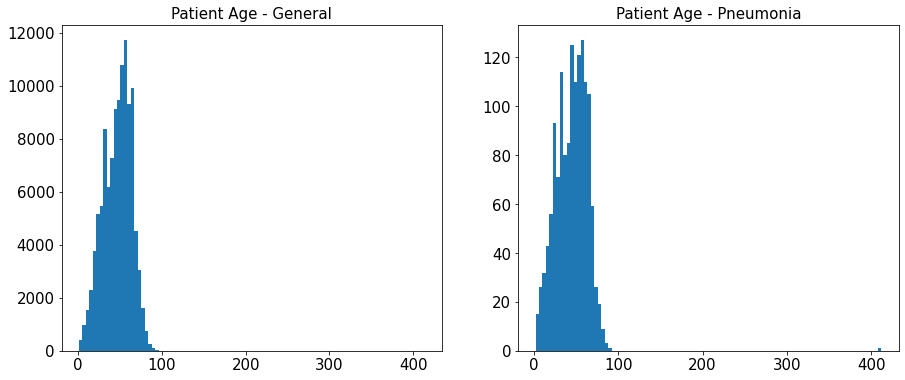

In [8]:
show_histograms(df['Patient Age'], df[df['Pneumonia'] == 1]['Patient Age'], 'Patient Age', 100)

Apparently there are some outliers:

In [9]:
df['Patient Age'][df['Patient Age'] > 100]

20852     412
46965     414
48284     148
55742     148
58650     150
62929     149
74884     152
78795     151
84810     411
85404     412
86264     413
91369     412
95794     153
98495     154
101194    155
104590    155
Name: Patient Age, dtype: int64

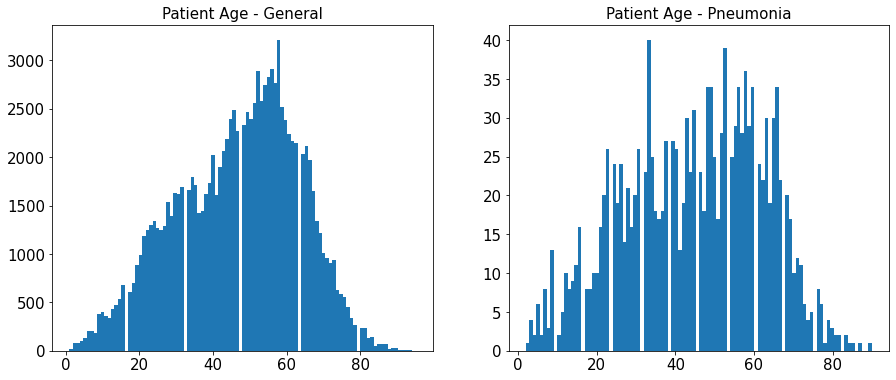

In [10]:
show_histograms(df['Patient Age'][df['Patient Age'] <= 100], df[df['Pneumonia'] == 1]['Patient Age'][df['Patient Age'] <= 100], 'Patient Age', 100)

Patients with only pneumonia:

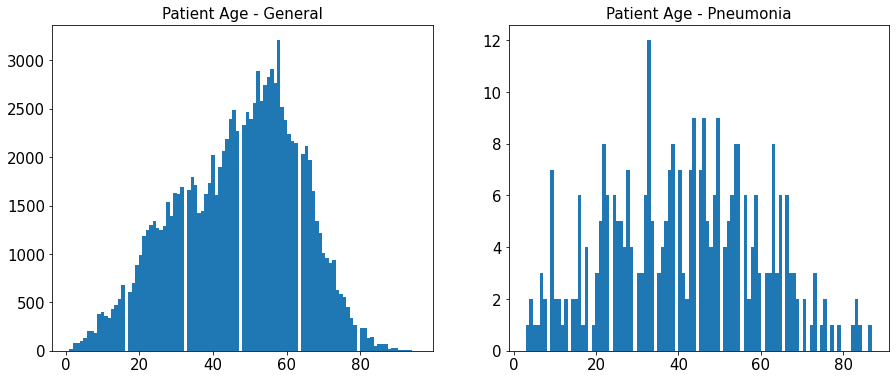

In [11]:
show_histograms(df['Patient Age'][df['Patient Age'] <= 100], df[df['Finding Labels'] == 'Pneumonia']['Patient Age'][df['Patient Age'] <= 100], 'Patient Age', 100)

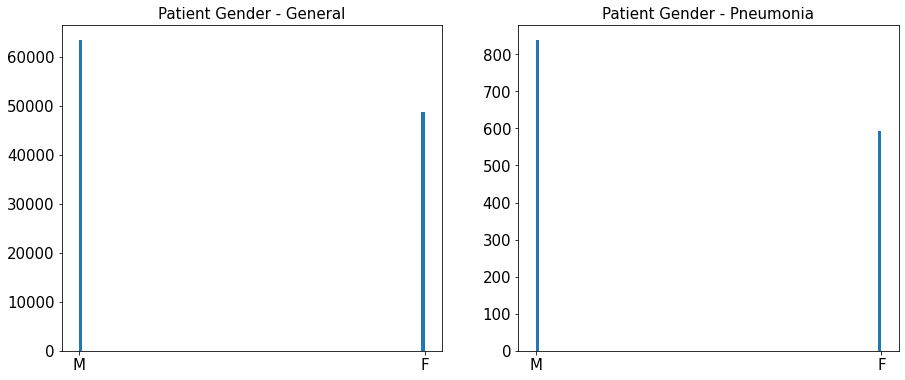

In [12]:
show_histograms(df['Patient Gender'], df[df['Pneumonia'] == 1]['Patient Gender'], 'Patient Gender', 2)

Patients with only pneumonia:

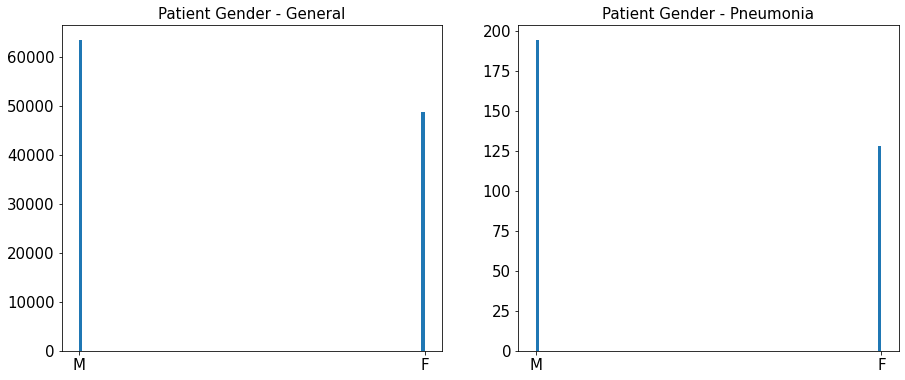

In [13]:
show_histograms(df['Patient Gender'], df[df['Finding Labels'] == 'Pneumonia']['Patient Gender'], 'Patient Gender', 2)

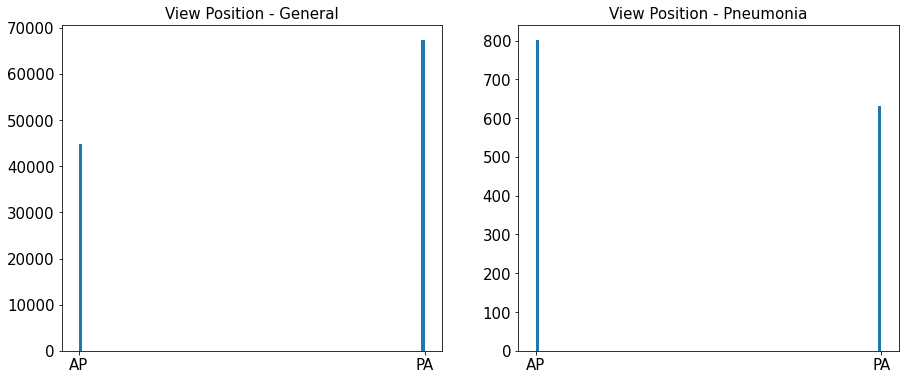

In [14]:
show_histograms(df['View Position'].sort_values(), df[df['Pneumonia'] == 1]['View Position'], 'View Position', 2)

Patients with only pneumonia:

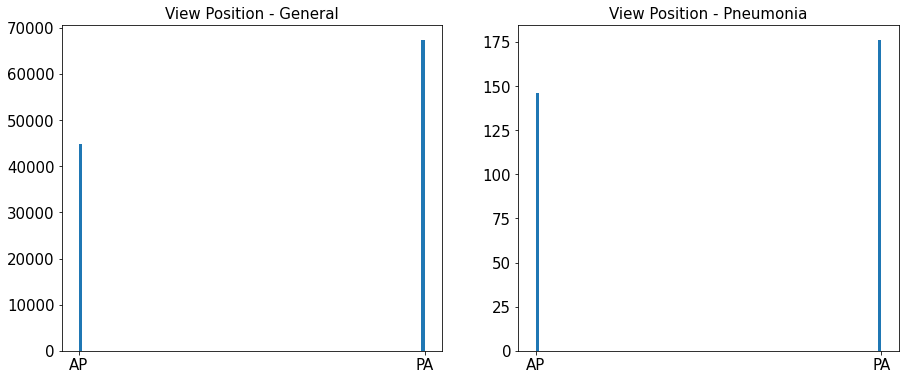

In [15]:
show_histograms(df['View Position'].sort_values(), df[df['Finding Labels'] == 'Pneumonia']['View Position'], 'View Position', 2)

Patients are aged mostly 40-60. There are more males in the dataset and there are more images taken in PA view. The pneumonia population follows the similar pattern apart from the 'View Position' - AP is more frequent.

## Findings

## Pneumonia and non-pneumonia cases

In [16]:
print('Pneumonia cases: ', len(df[df['Pneumonia'] == 1]))
print('Non-pneumonia cases: ', len(df[df['Pneumonia'] == 0]))

Pneumonia cases:  1431
Non-pneumonia cases:  110689


There are only 1431 cases with the disease of interest in the whole dataset.

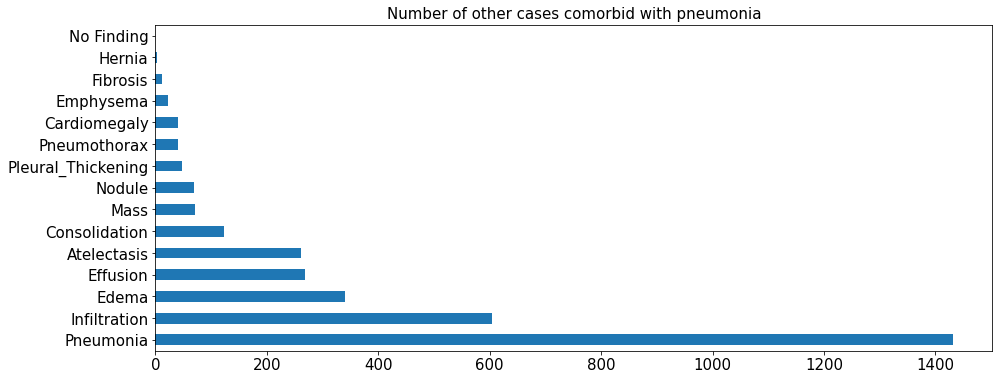

In [17]:
df[df['Pneumonia'] == 1][all_labels].sum().sort_values(ascending=False).plot(kind='barh', figsize=(15,6))
plt.title('Number of other cases comorbid with pneumonia', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Obviously, 'No Finding' is 0, since it cannot appear with any other label. It seems that the most commonly appearing pneumonia comorbidity is 'Infiltration' and the least common 'Hernia'. It can be seen as well on the plot below.

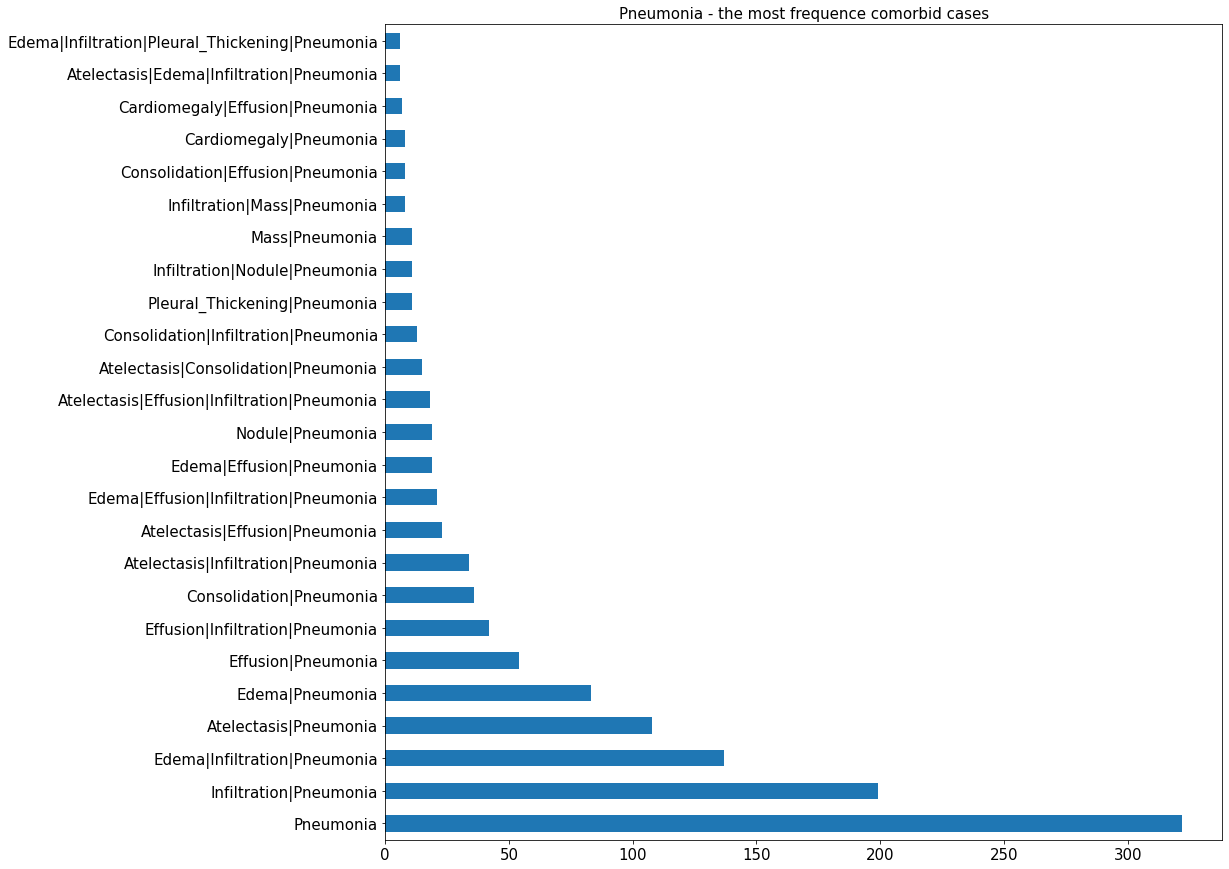

In [18]:
df[df['Pneumonia'] == 1]['Finding Labels'].value_counts().sort_values(ascending=False)[:25].plot(kind='barh', figsize=(15,15))
plt.title('Pneumonia - the most frequence comorbid cases', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

## Number of diseases per patient

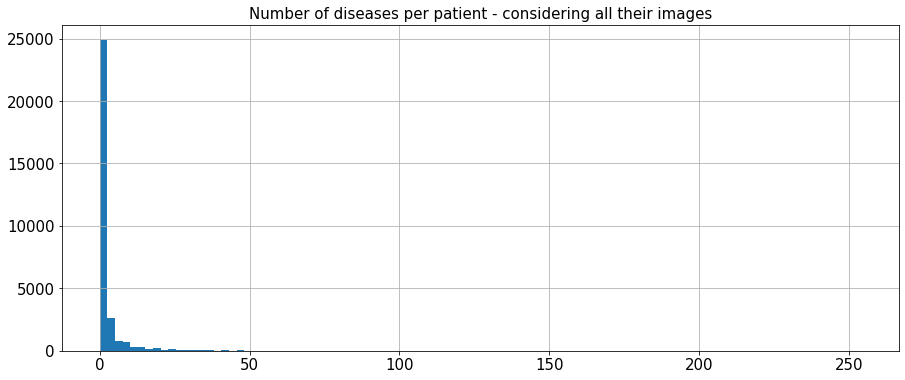

In [19]:
df.groupby('Patient ID')[all_labels].sum().drop(columns='No Finding').sum(axis=1).hist(bins=100, figsize=(15,6))
plt.title('Number of diseases per patient - considering all their images', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [20]:
max(df.groupby('Patient ID')[all_labels].sum().drop(columns='No Finding').sum(axis=1))

254

There are some patients whose number of images in the dataset is quite big and thus their number of all cases from every image is also high (reaching 254 for one of the patients).

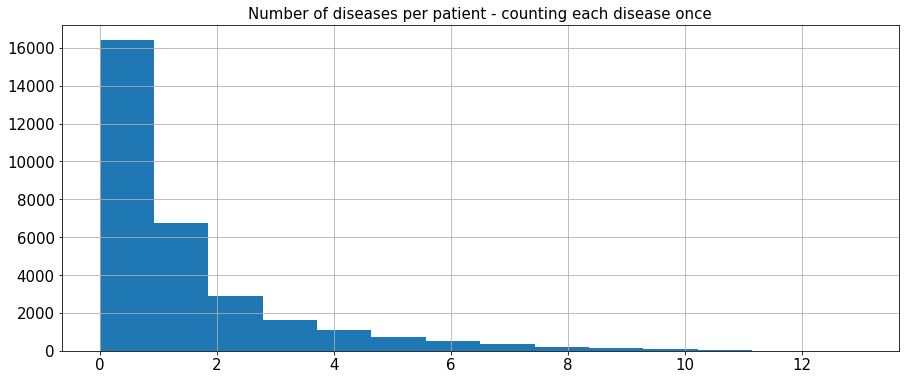

In [21]:
df.groupby('Patient ID')[all_labels].sum().drop(columns='No Finding').astype('bool').sum(axis=1).hist(bins=len(all_labels)-1, figsize=(15,6))
plt.title('Number of diseases per patient - counting each disease once', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In most cases patients are diagnosed with one disease. However, there are also some patients diagnosed with 8 and more diseases.

In [22]:
len(df[df['No Finding'] == 1]), len(df), len(df[df['No Finding'] == 1])/len(df)

(60361, 112120, 0.5383606849803781)

More than half of the patients in the dataset have no disease.

## Pixel-level assessments

To ease the visual comparisons between intensity histograms, all the charts for whole images have y-axis maximum set to 10000. This will also help to avoid background pixels influence on the overall histogram appearance. On the other hand, histograms for images fragments have maximum set to 600.

In [20]:
sample_df.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168

Prepare one-hot columns for sample_df:

In [23]:
for label in all_labels:
    sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
    
sample_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax'],
      dtype='object')

Collect all images paths:

In [24]:
img_paths = [glob(f"/data/images*/*/{i}")[0] for i in sample_df['Image Index'].values]
img_paths[0]

'/data/images_001/images/00000013_005.png'

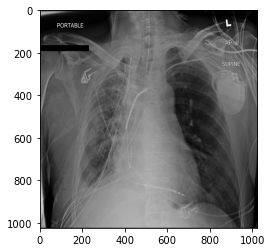

In [25]:
plt.imshow(Image.open(img_paths[0]), cmap='gray');

In [26]:
images_paths = []

for img in sample_df['Image Index'].values:
    for img_path in img_paths:
        if img == img_path.split('/')[-1]:
            images_paths.append(img_path)

sample_df['Image Path'] = images_paths
sample_df.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
0         0       0             1     0           0       0   
1         0       0             0     0           0       0   
2         0       0             0     0           1       0   
3         0       0             0     0           0       0   
4         0       0             0     0           0       0   

   Pleural_Thickening  Pneumonia  Pneumothorax  \
0                   1          0             1   
1                   0          0             0   
2                   0          0             0   
3                   0          0             0   
4                   0          0             0   

                                 Image Path  
0  /data/images_001/images/00000013_005.png  
1  /data/images_001/images/00000013_026.png  
2  /data/images_001/images/00000017_001.png  
3  /data/images_001/images/00000030_001.png  
4  /data/images_001/images/00000032_001.png  

[5 rows x 27 columns]

In [43]:
def plot_intensity(img_path, title, if_fragment=False, y=400, x=250):
    img_ = plt.imread(img_path)
    
    if if_fragment:
        img_ = img_[y:y+100, x:x+100]
        y_max = 600
    else:
        y_max = 10000
    
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.imshow(img_, cmap='gray')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.subplot(122)
    plt.hist(img_.ravel(), bins=256)
    plt.ylim(0, y_max)
    plt.xlim(0, 1)
    
    plt.tight_layout();

### Pneumonia

In [28]:
len(sample_df[sample_df['Finding Labels'] == 'Pneumonia'])

14

Since there are only 14 only-pneumonia cases in the sample dataset, let's plot them all:

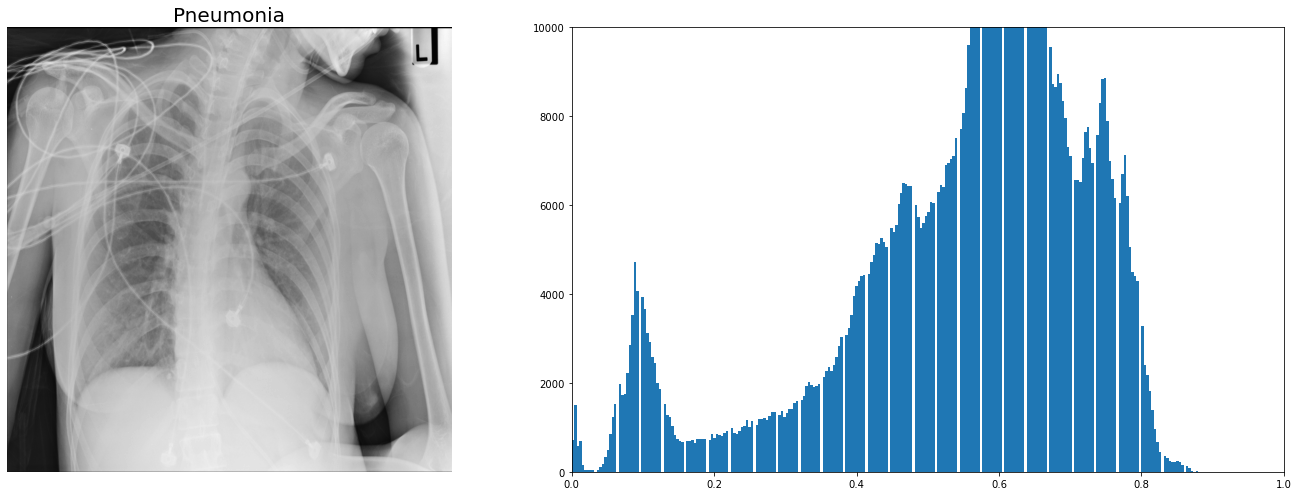

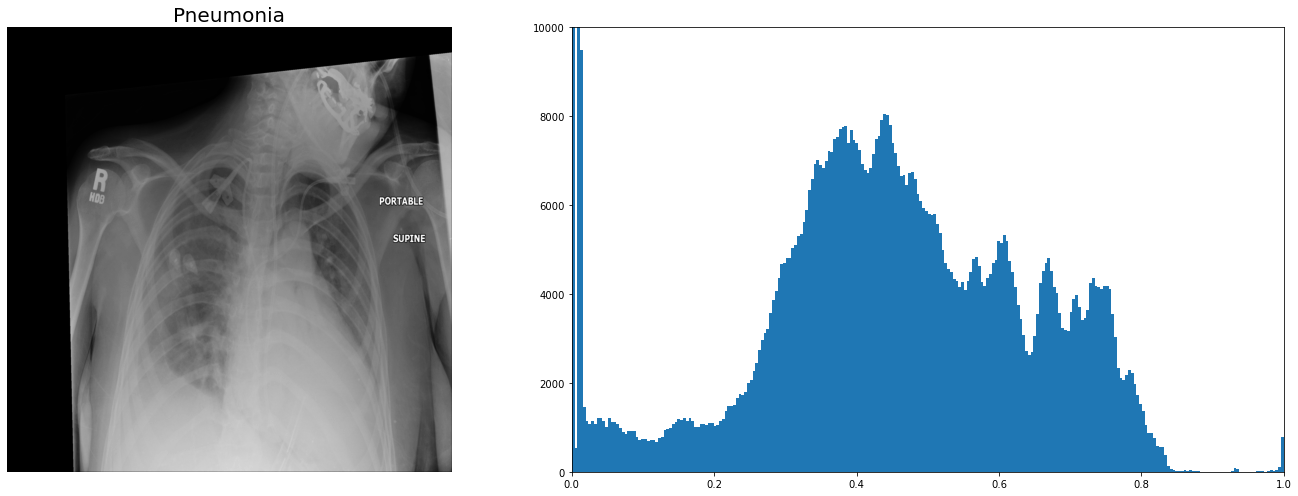

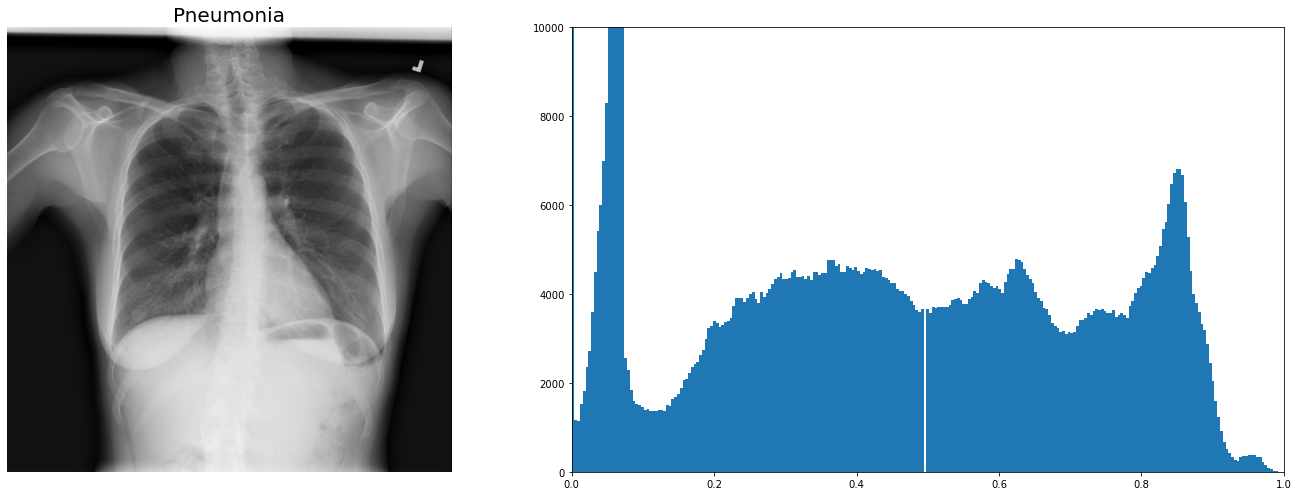

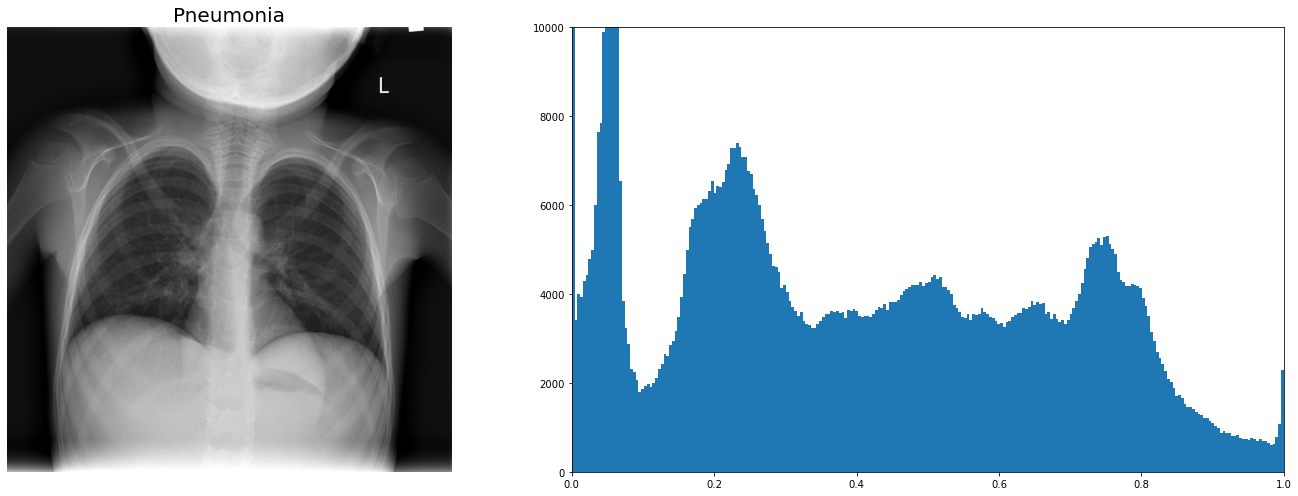

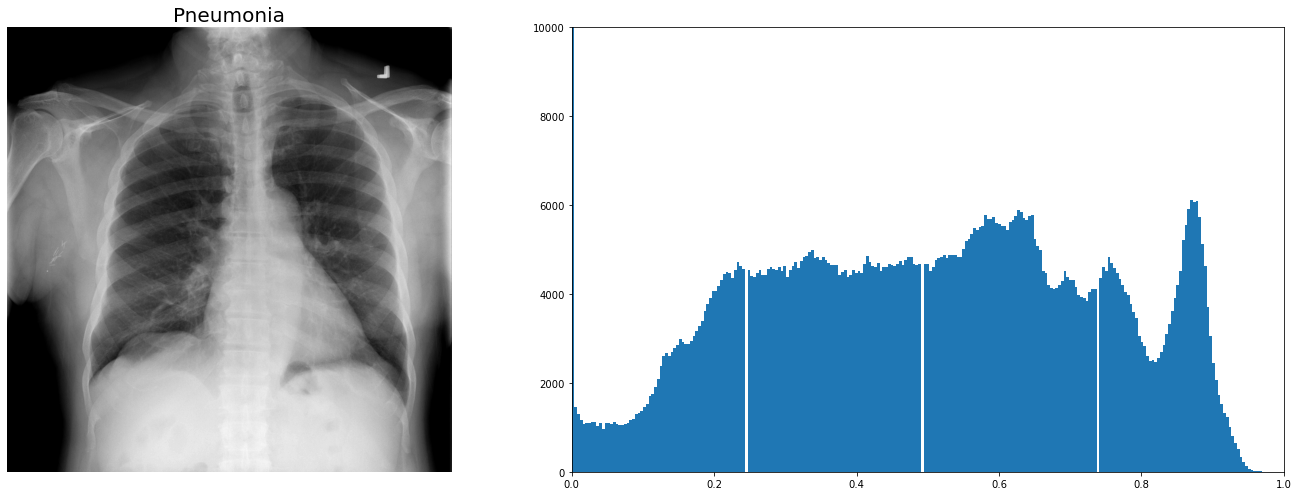

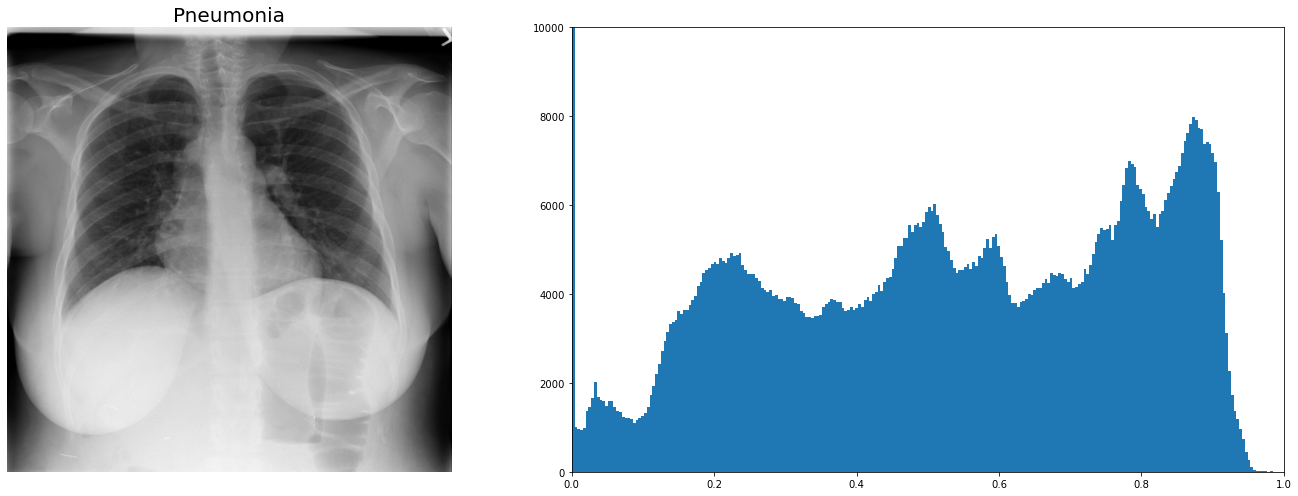

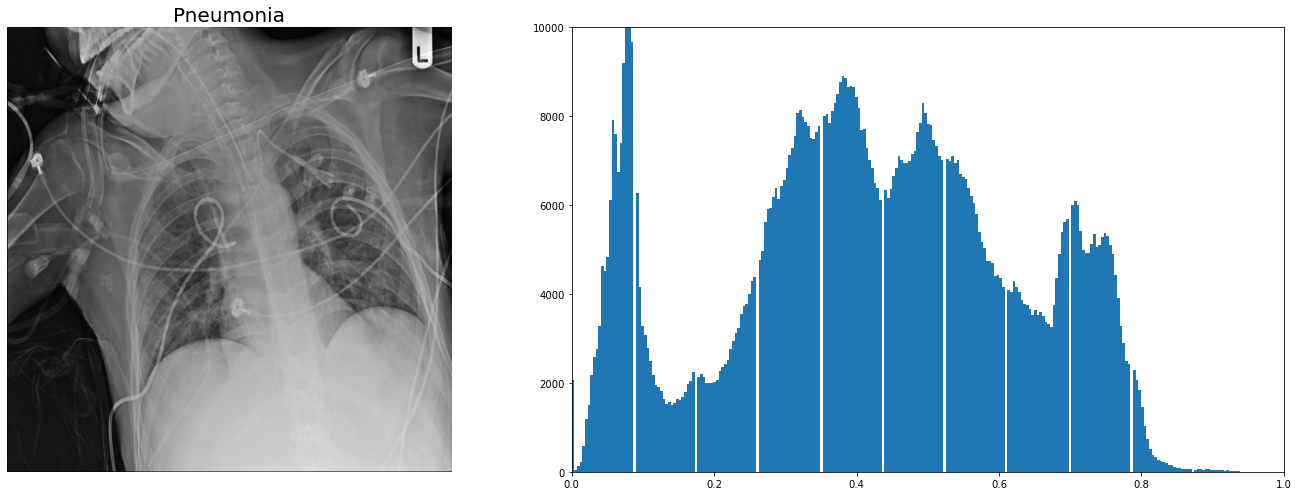

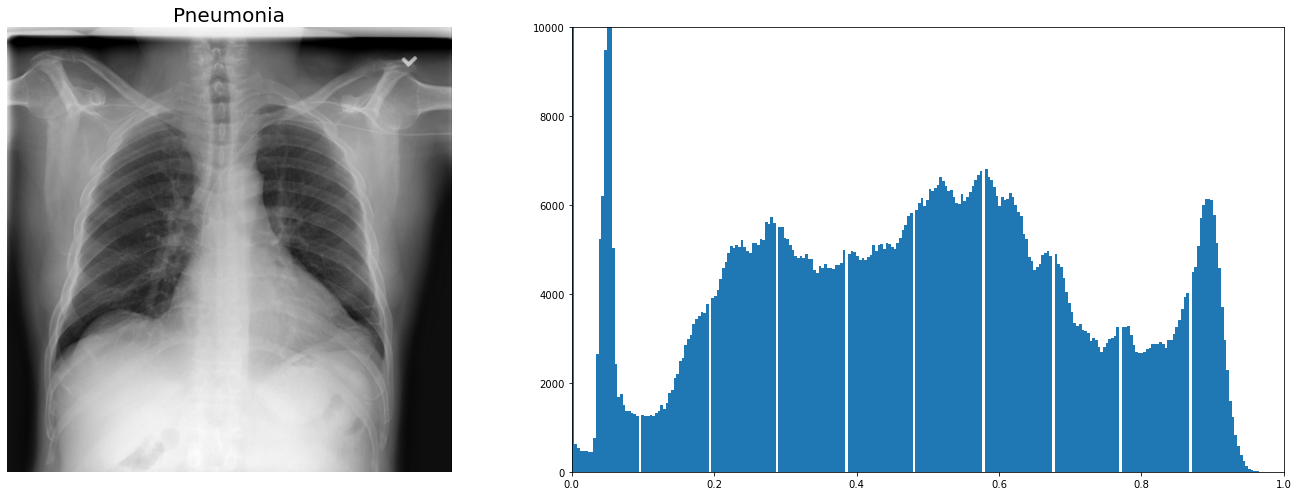

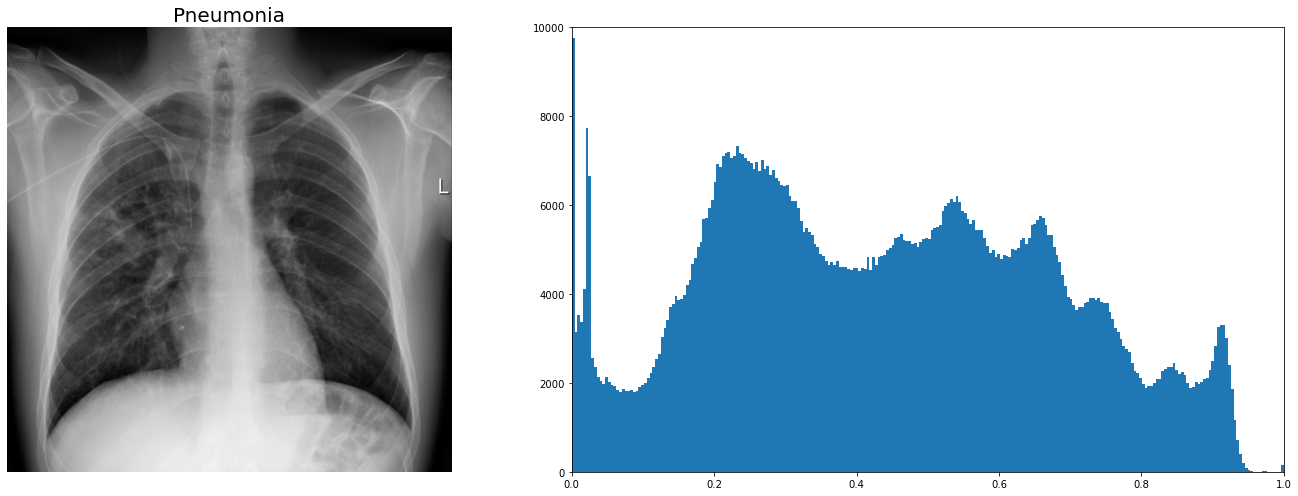

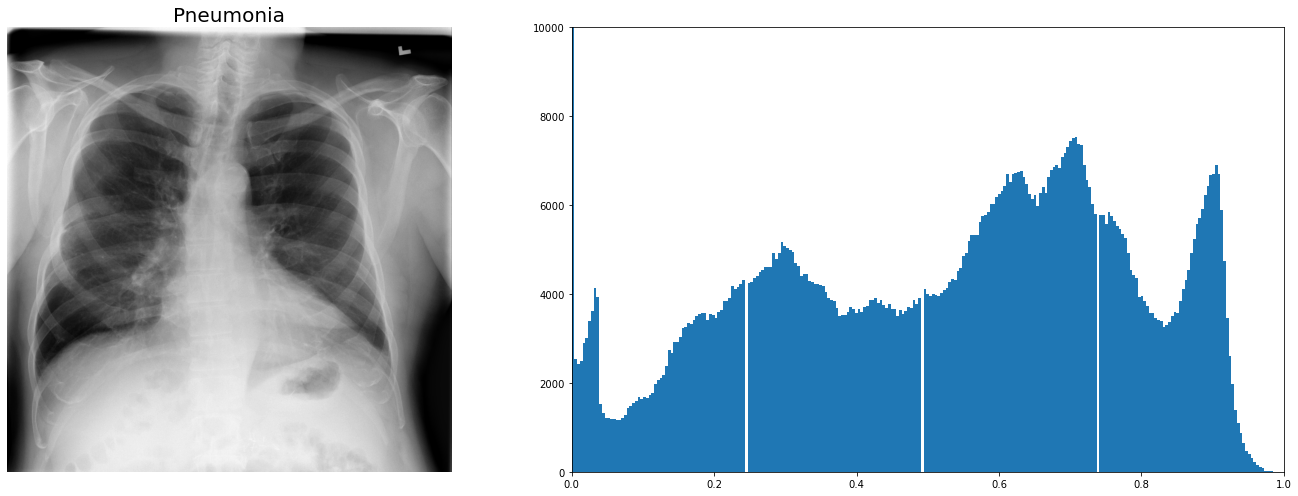

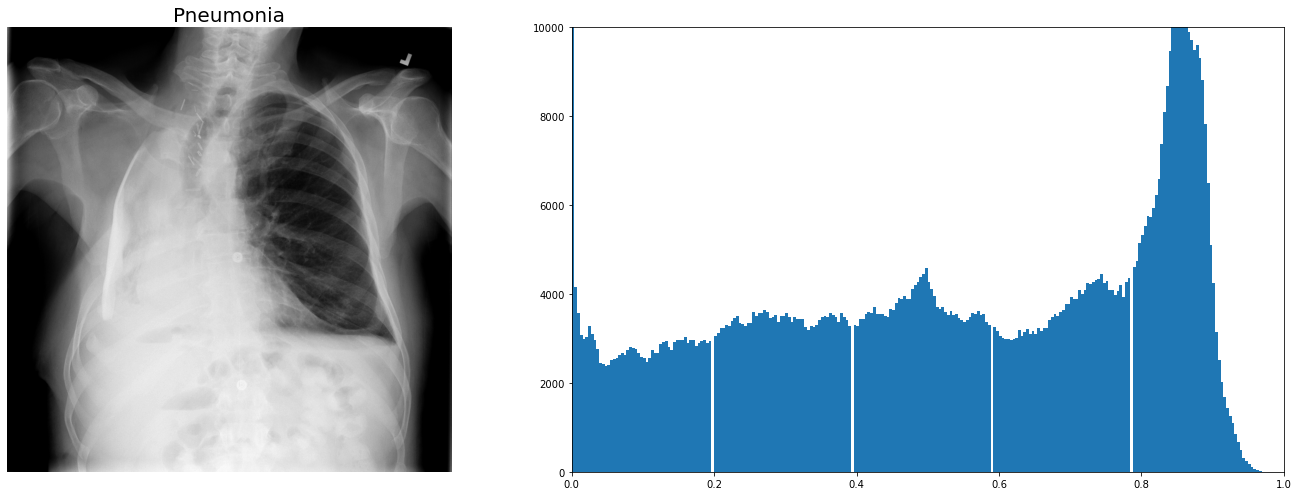

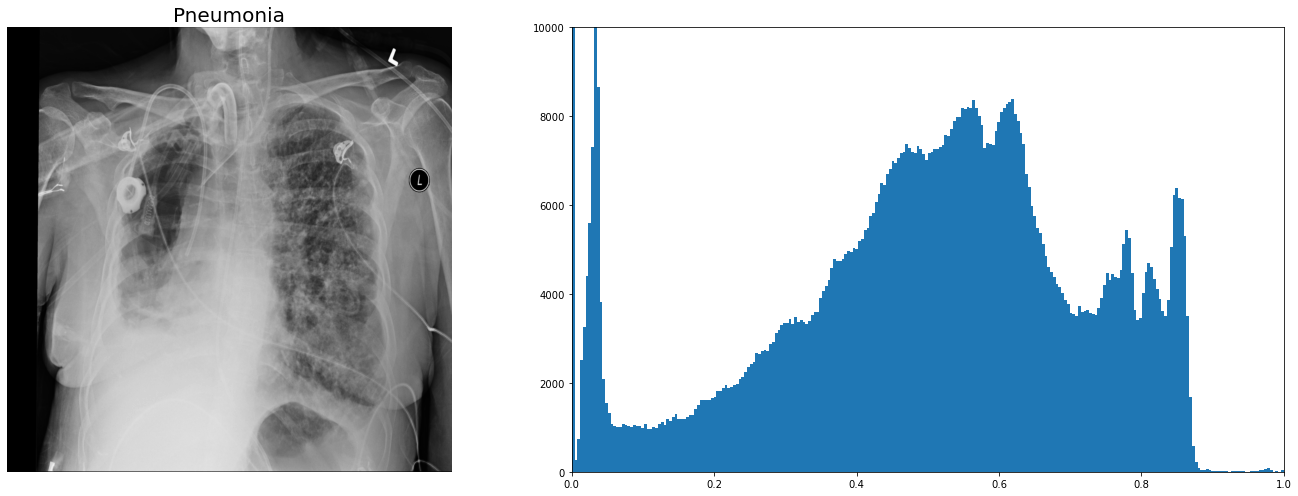

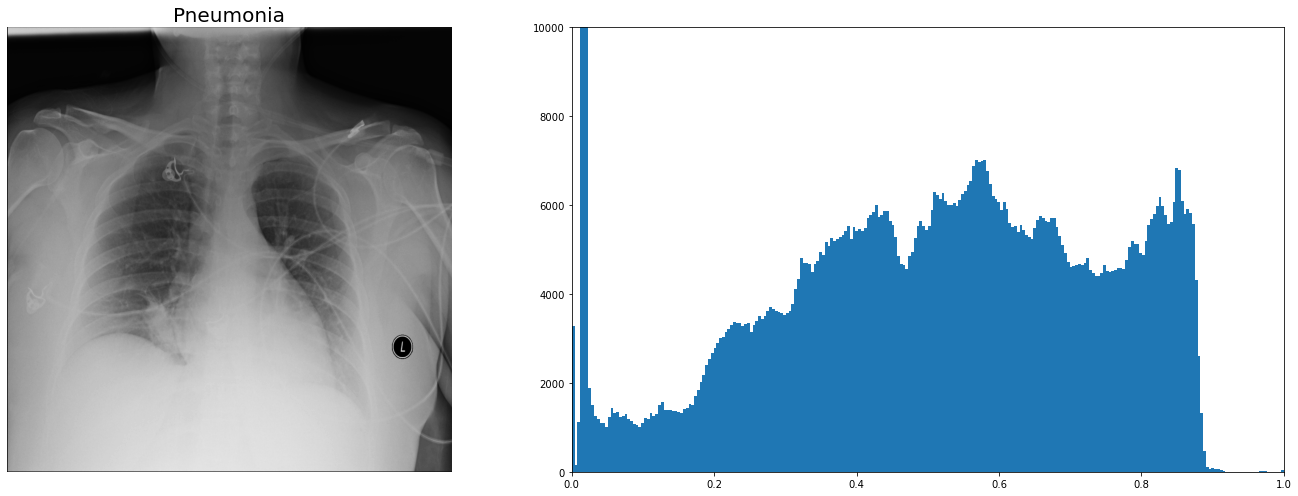

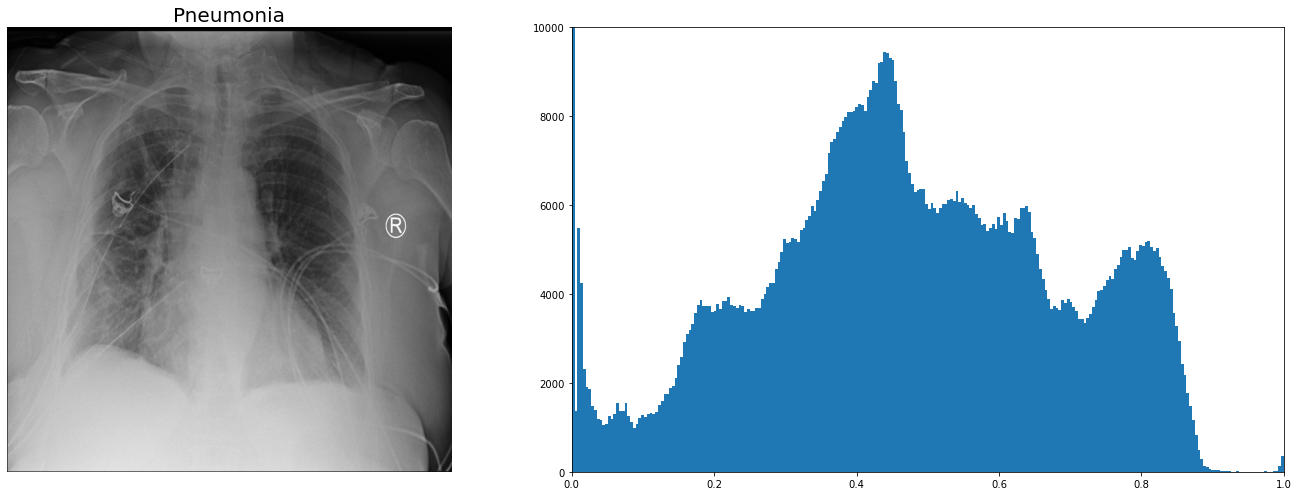

In [39]:
for i in range(len(sample_df[sample_df['Finding Labels'] == 'Pneumonia'])):
    plot_intensity(sample_df[sample_df['Finding Labels'] == 'Pneumonia']['Image Path'].values[i],
                   title='Pneumonia')

Pneumonia appears on radiographs as areas whiter than healthy lungs. We would expect the intensity histogram shifted rather to the right side (not considering the zero background peak). Some of the above picture have noise, like wires, on some there is little background. Before choosing one of them for comparisons with other diseases, let's plot intensity histogram of the smaller part of the image containing only lungs (100 x 100 px).

In [31]:
def fragment_intensity(img_path, y, x, title):
    plt.figure(figsize=(6,6))
    img = plt.imread(img_path)
    img[y:y+100, x:x+100] = 0
    plt.imshow(img, cmap='gray')
    
    plot_intensity(img_path, title, y=y, x=x, if_fragment=True)

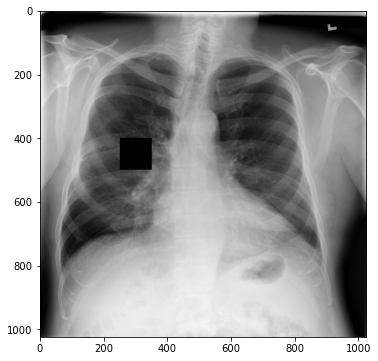

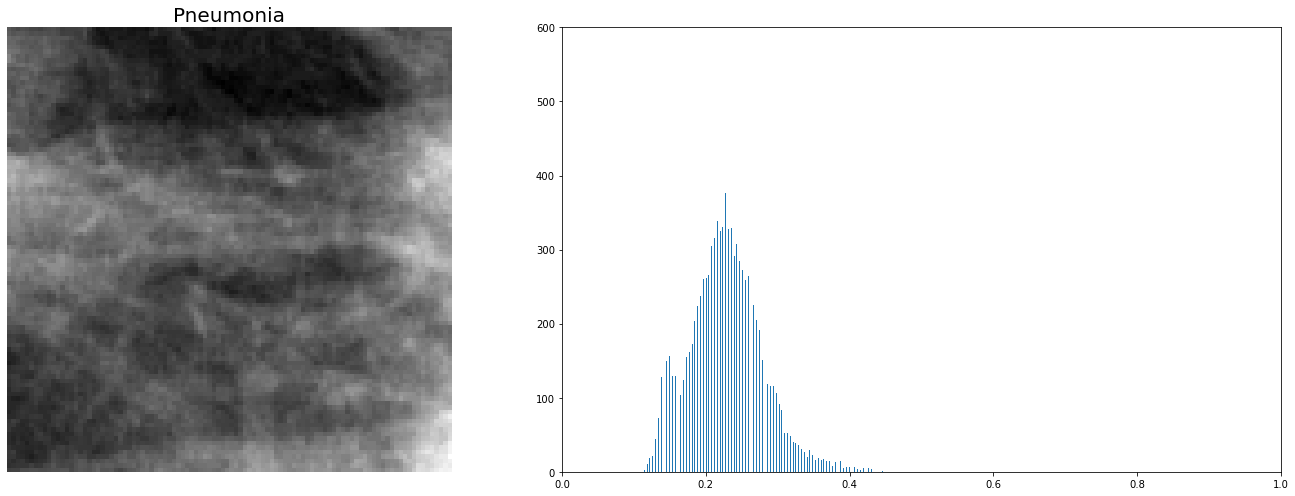

In [44]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Pneumonia']['Image Path'].values[9],
                   y=400, x=250, title='Pneumonia')

Interpreting radiograph intensity is challenging, because apart from our region of interest (here:lungs) there are also other structures that veil parts of the image (like ribs) and contribute to the overall intensity histogram. There can be also other things, like wires or annotations, that influence the intensity and thus it is beneficial to analyze only small part of the image containing lungs.

### No Finding

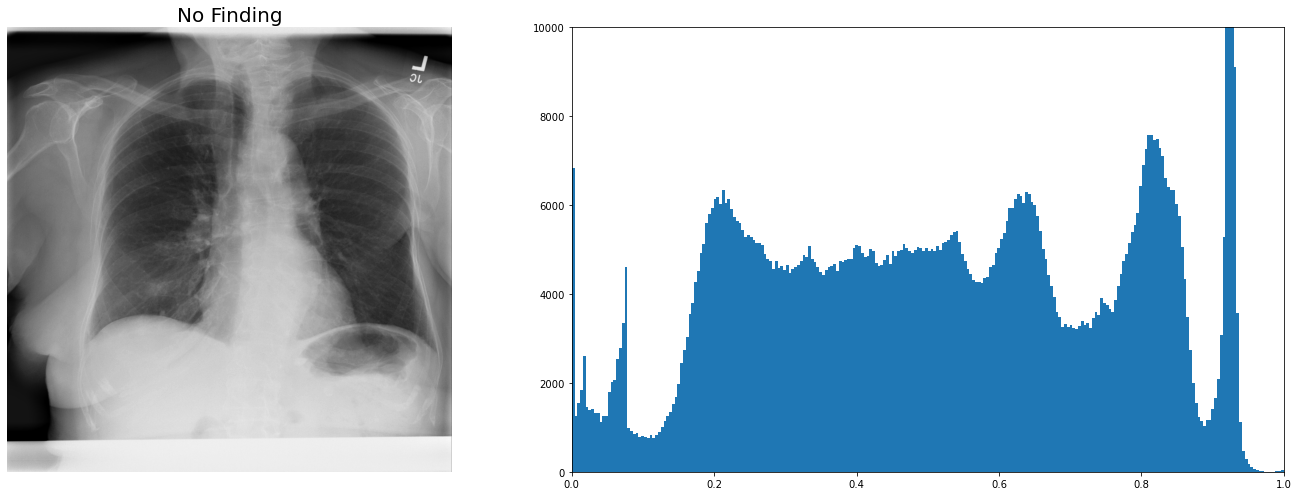

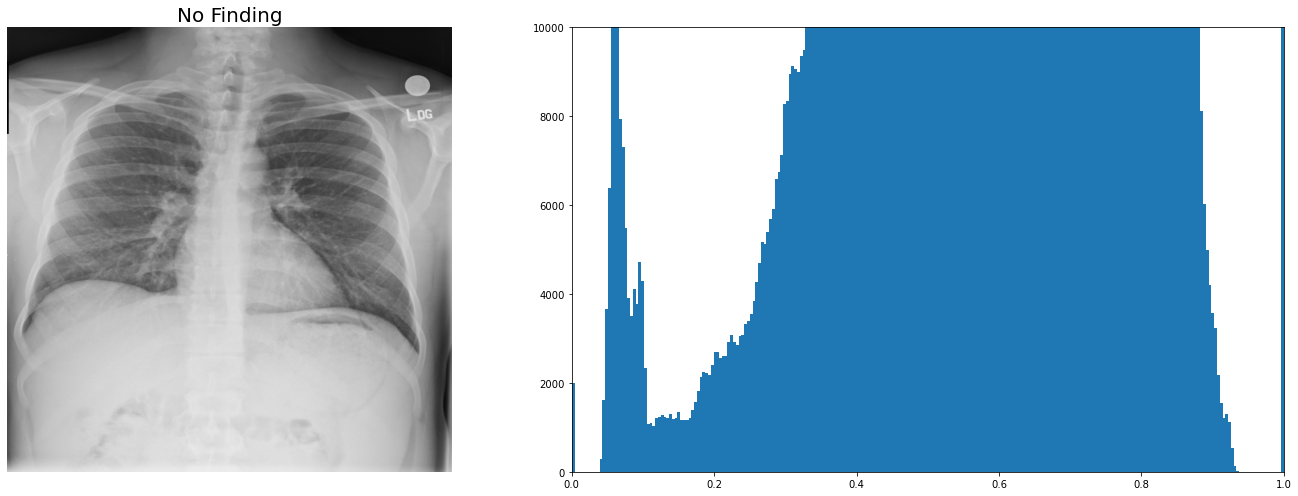

In [41]:
for i in range(3):
    plot_intensity(sample_df[sample_df['Finding Labels'] == 'No Finding']['Image Path'].values[i+10], 
                   title='No Finding')

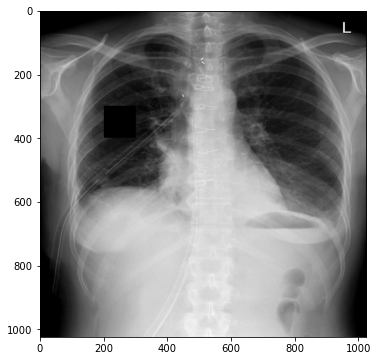

In [45]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'No Finding']['Image Path'].values[12],
                   y=300, x=200, title='No Finding')

The lungs with no disease are darker than the ones with pneumonia.

### Pneumonia and Infiltration

Infiltration is the most common comorbidity.

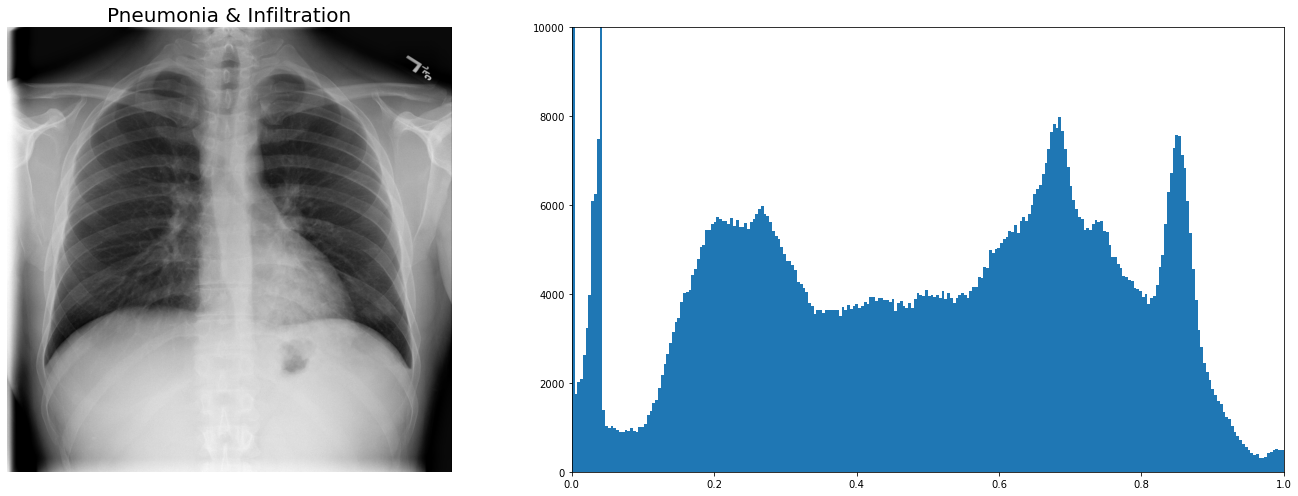

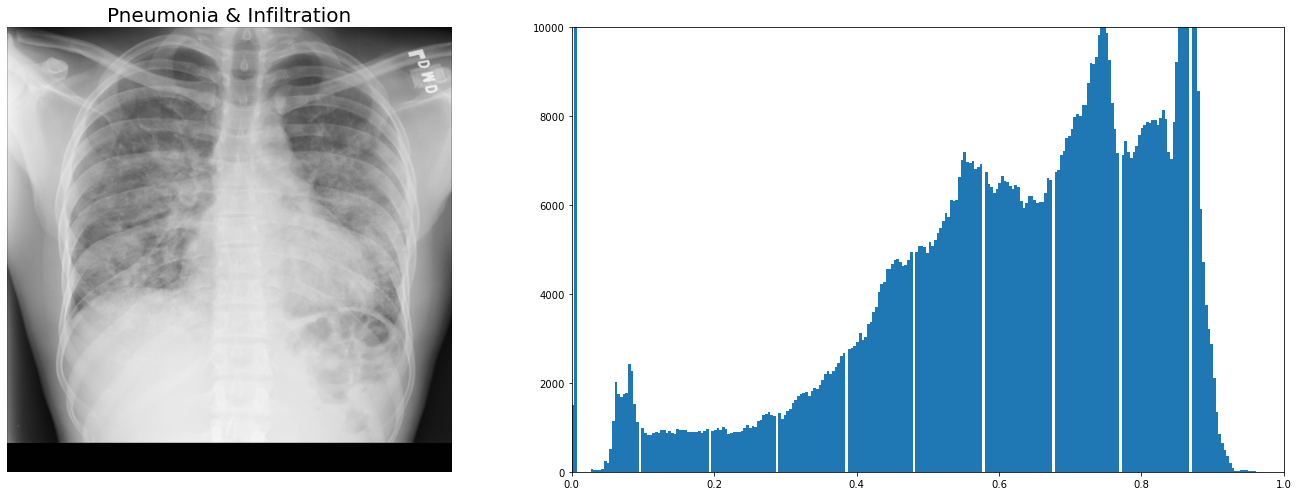

In [46]:
for i in range(3):
    plot_intensity(sample_df[(sample_df['Finding Labels'] == 'Pneumonia|Infiltration') | \
                             (sample_df['Finding Labels'] == 'Infiltration|Pneumonia')]['Image Path'].values[i],
                   title='Pneumonia & Infiltration')

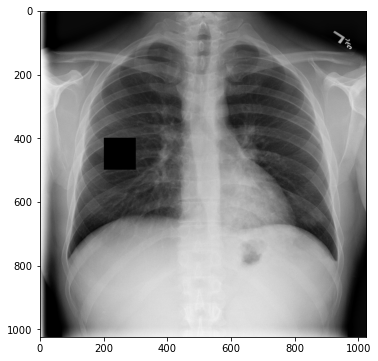

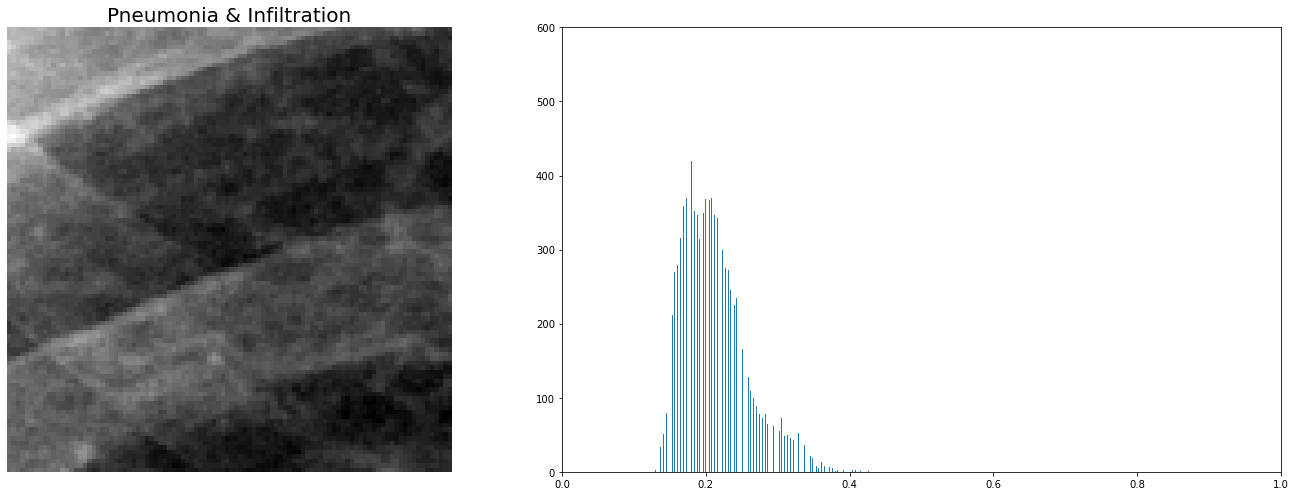

In [47]:
fragment_intensity(sample_df[(sample_df['Finding Labels'] == 'Pneumonia|Infiltration') | \
                             (sample_df['Finding Labels'] == 'Infiltration|Pneumonia')]['Image Path'].values[0],
                   y=400, x=200, title='Pneumonia & Infiltration')

### Infiltration

**Infiltration** - pathological accumulation in tissue or cells of substances not normal to them or in amounts in excess of the normal.

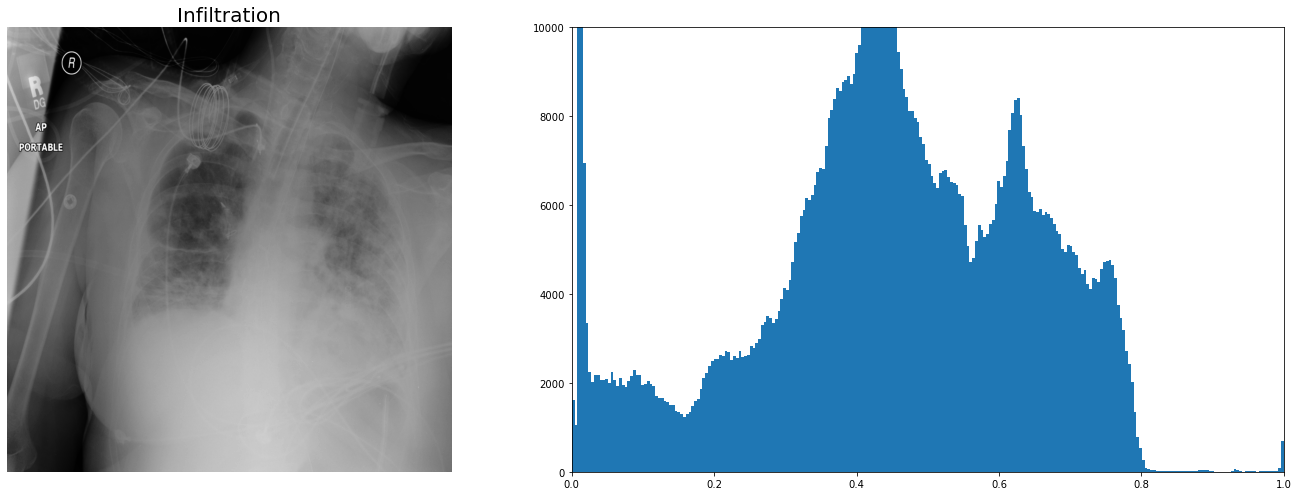

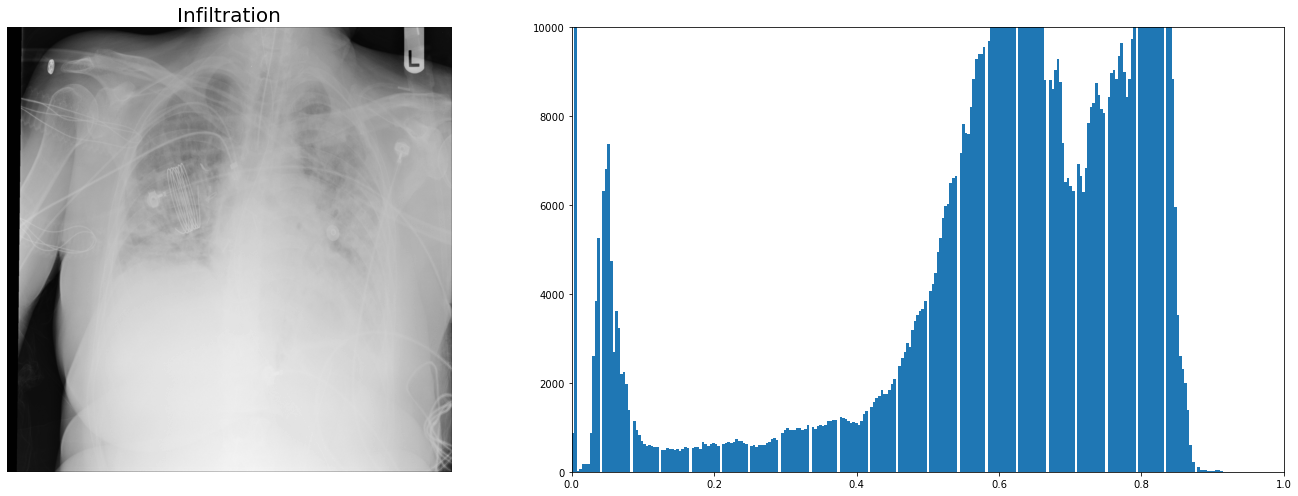

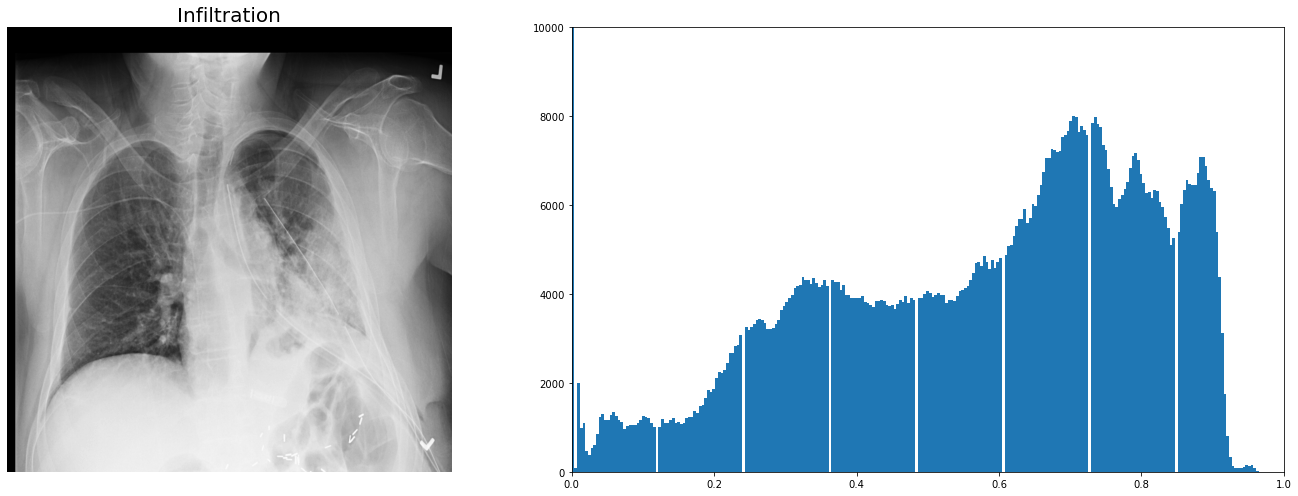

In [48]:
for i in range(3):
    plot_intensity(sample_df[sample_df['Finding Labels'] == 'Infiltration']['Image Path'].values[i], 
                   title='Infiltration')

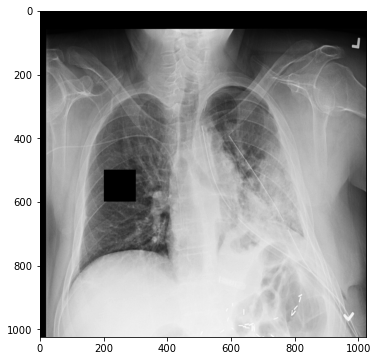

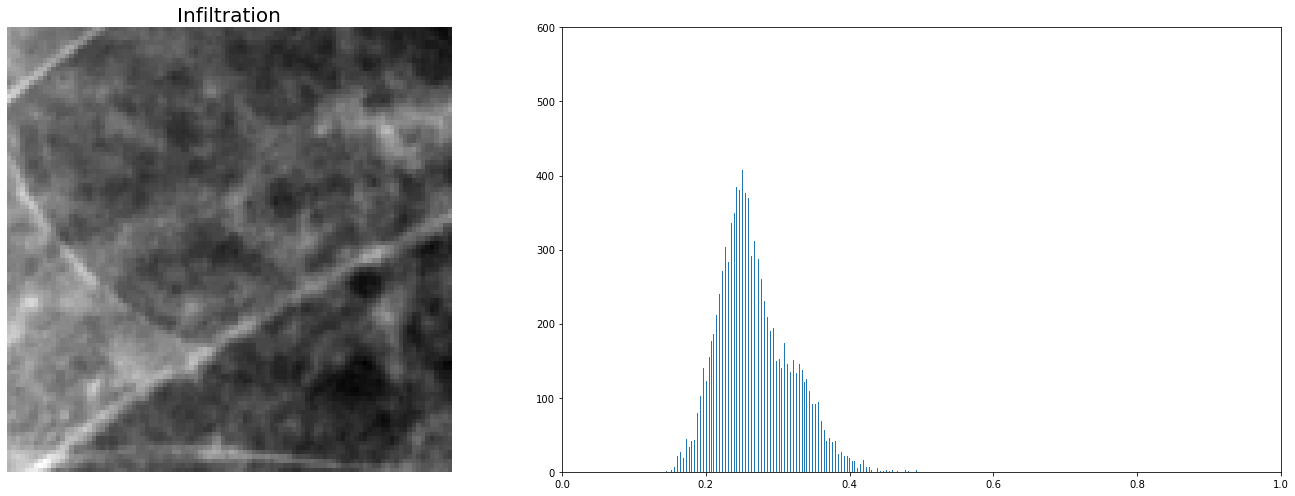

In [49]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Infiltration']['Image Path'].values[2],
                   y=500, x=200, title='Infiltration')

### Pneumonia and Edema

Edema is the second most common comorbidity.

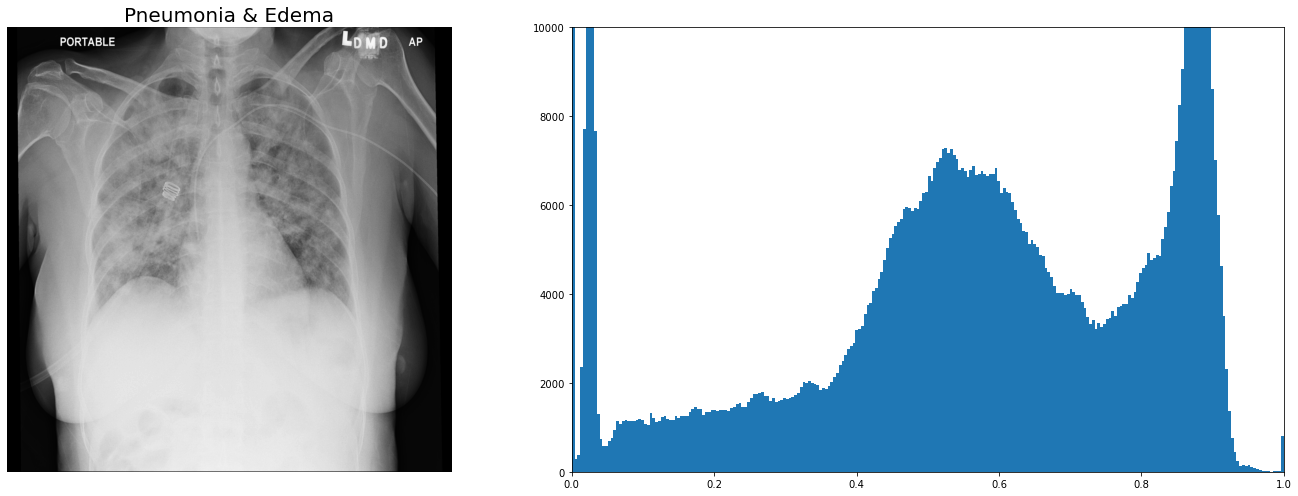

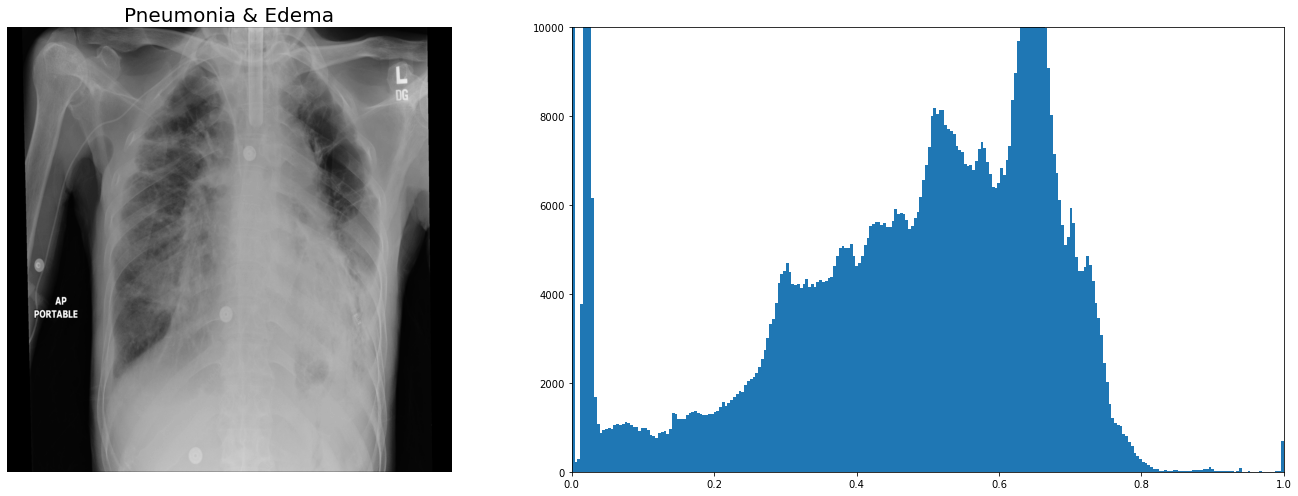

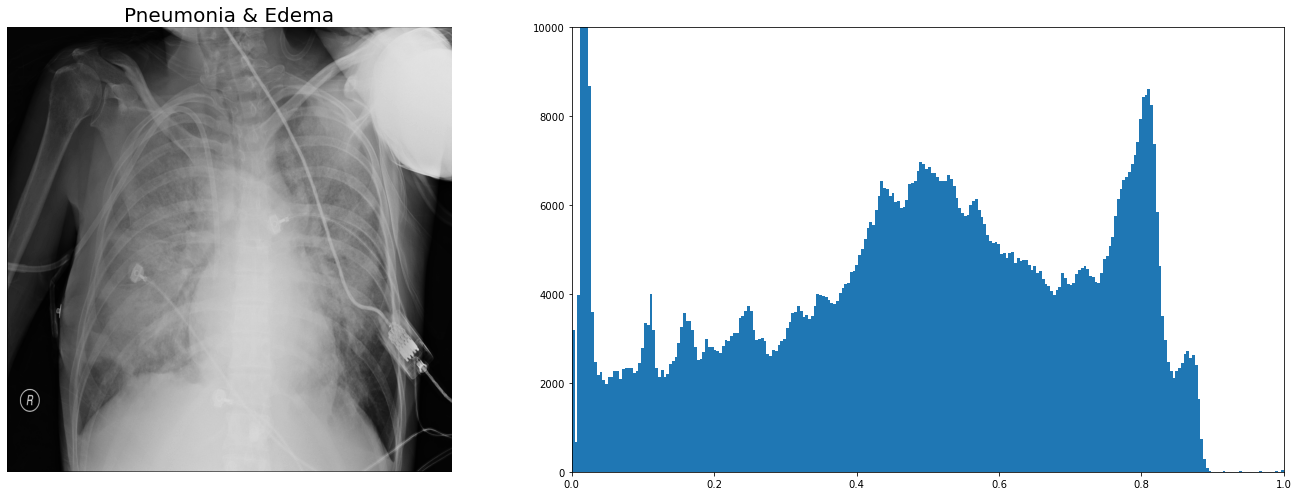

In [50]:
for i in range(3):
    plot_intensity(sample_df[(sample_df['Finding Labels'] == 'Pneumonia|Edema') | \
                             (sample_df['Finding Labels'] == 'Edema|Pneumonia')]['Image Path'].values[i],
                   title='Pneumonia & Edema')

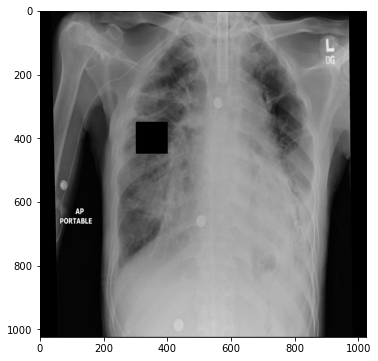

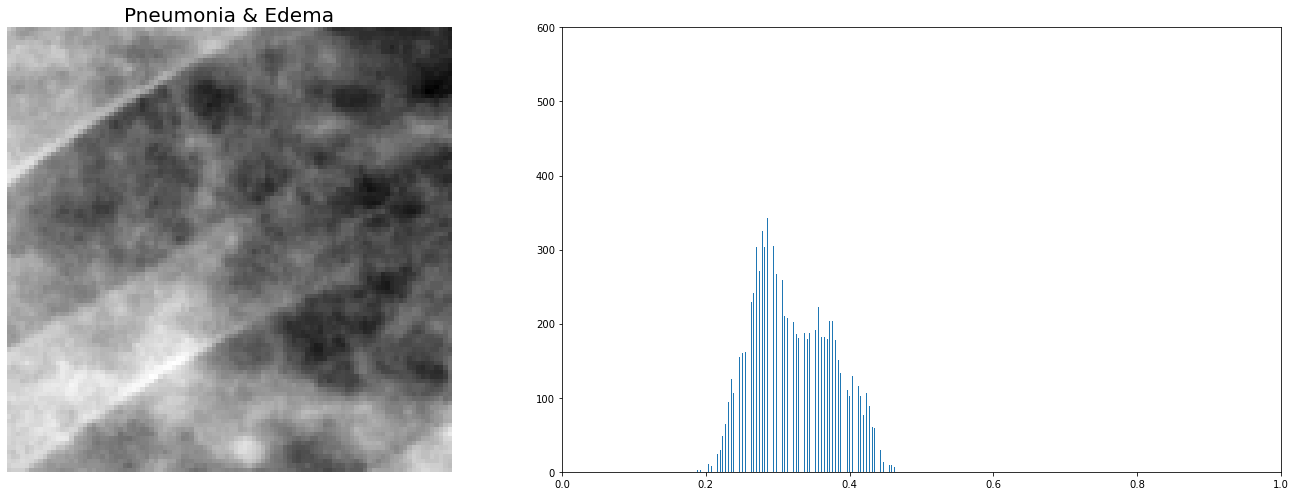

In [51]:
fragment_intensity(sample_df[(sample_df['Finding Labels'] == 'Pneumonia|Edema') | \
                             (sample_df['Finding Labels'] == 'Edema|Pneumonia')]['Image Path'].values[1],
                   y=350, x=300, title='Pneumonia & Edema')

### Edema

**Edema** - excess fluid in the lungs.

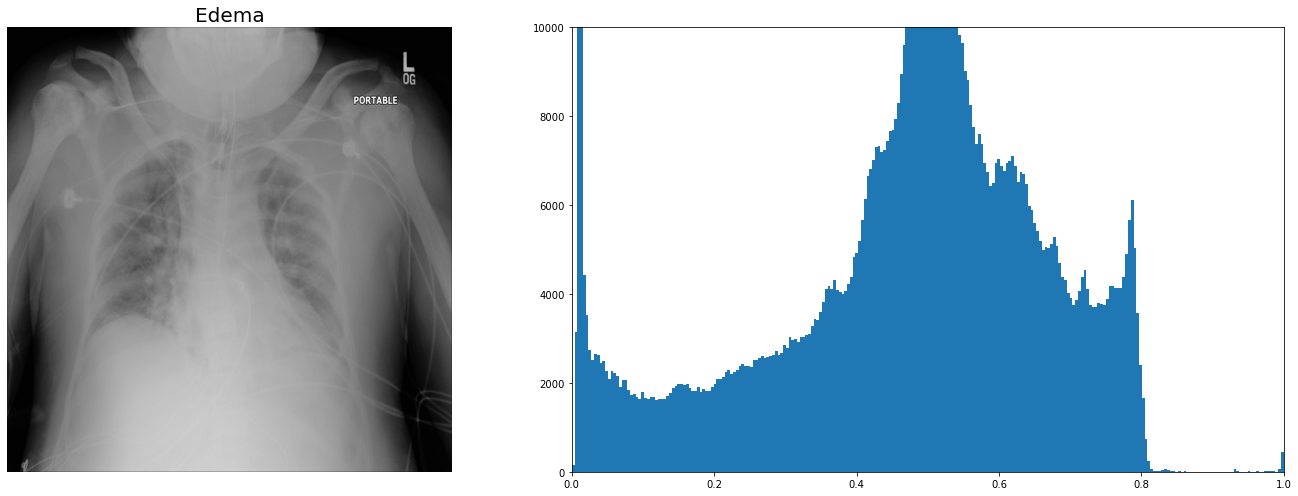

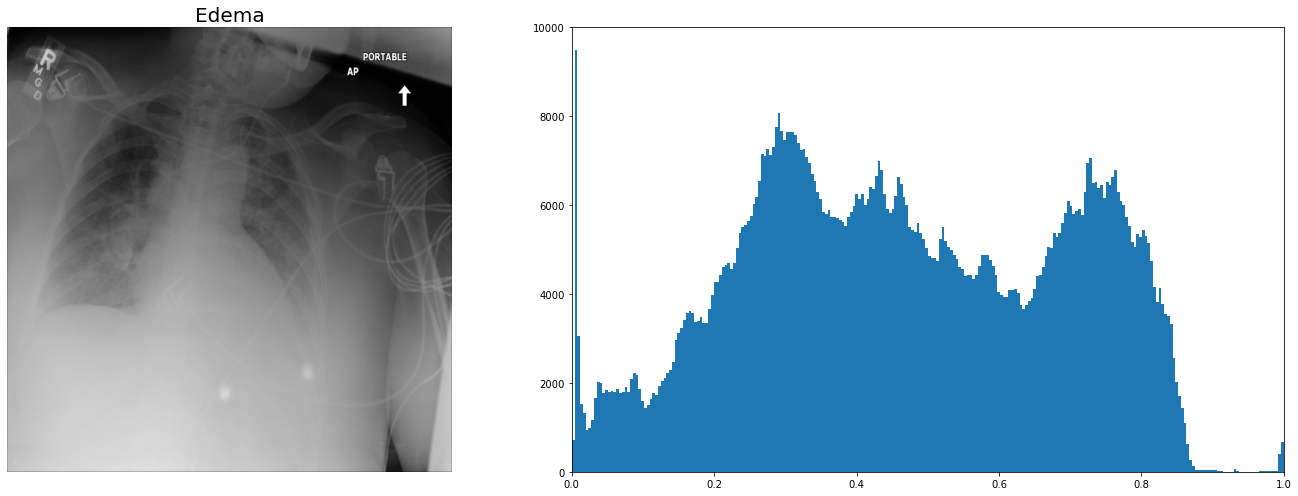

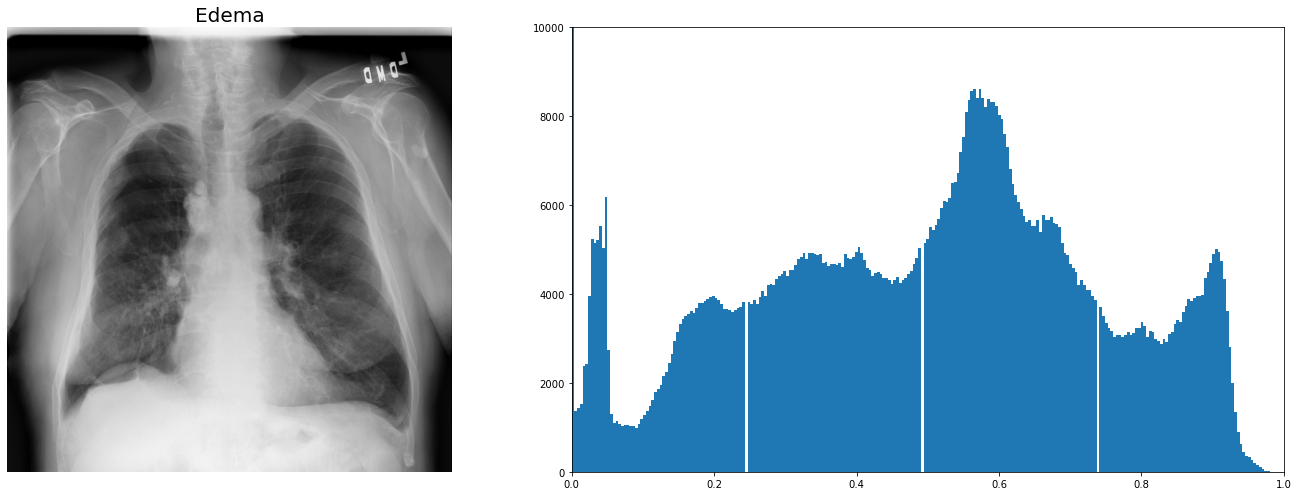

In [52]:
for i in range(3):
    plot_intensity(sample_df[sample_df['Finding Labels'] == 'Edema']['Image Path'].values[i], 
                   title='Edema')

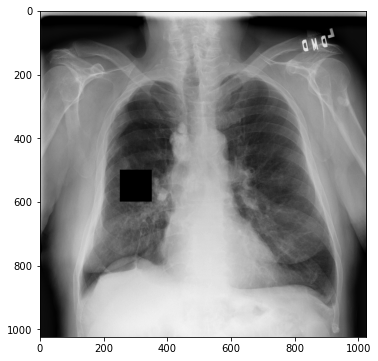

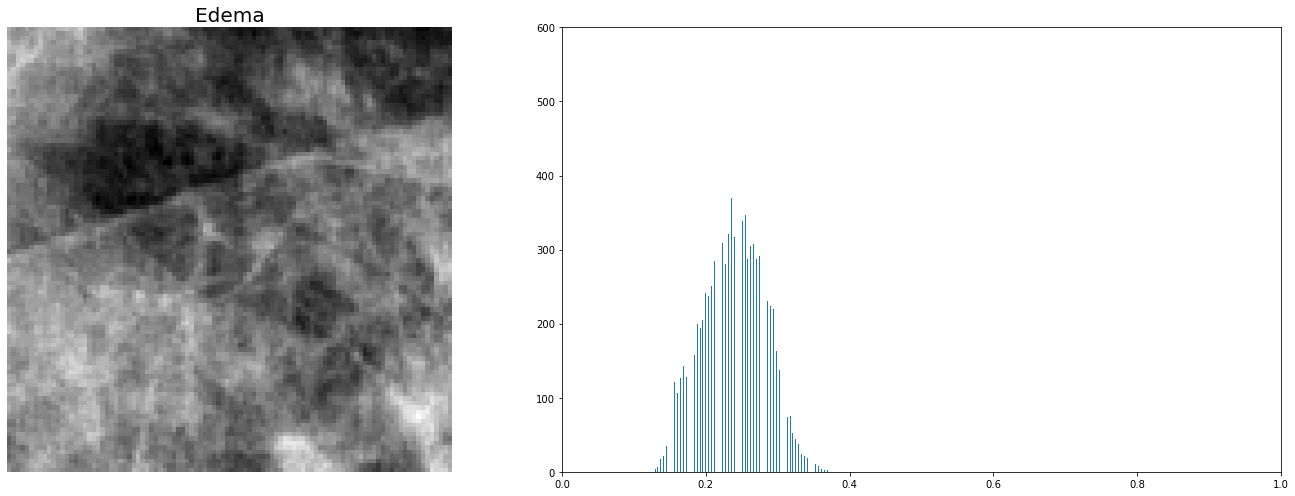

In [53]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Edema']['Image Path'].values[2],
                   y=500, x=250, title='Edema')

### Other diseases

**Atelectasis** - collapse or closure of a lung resulting in reduced or absent gas exchange.

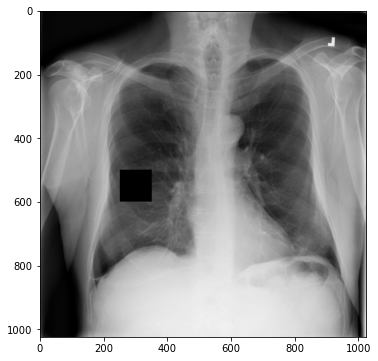

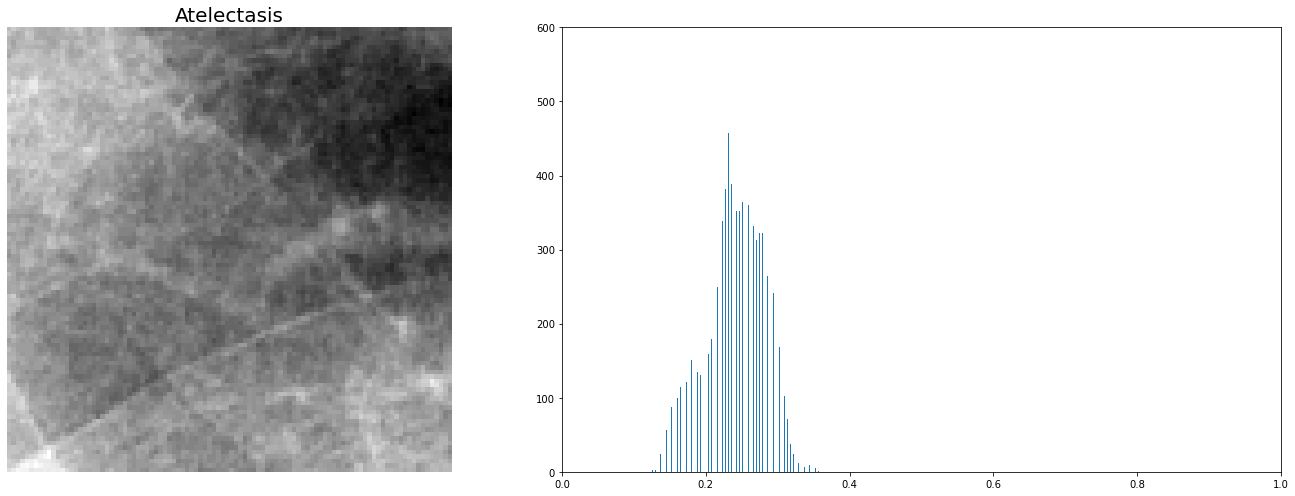

In [54]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Atelectasis']['Image Path'].values[0],
                   y=500, x=250, title='Atelectasis')

**Cardiomegaly** - medical condition in which the heart is enlarged.

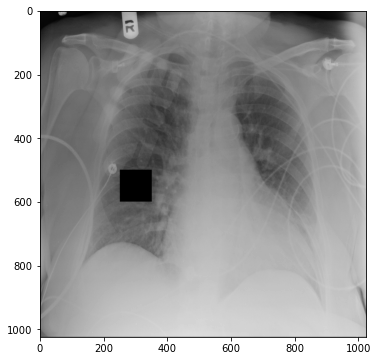

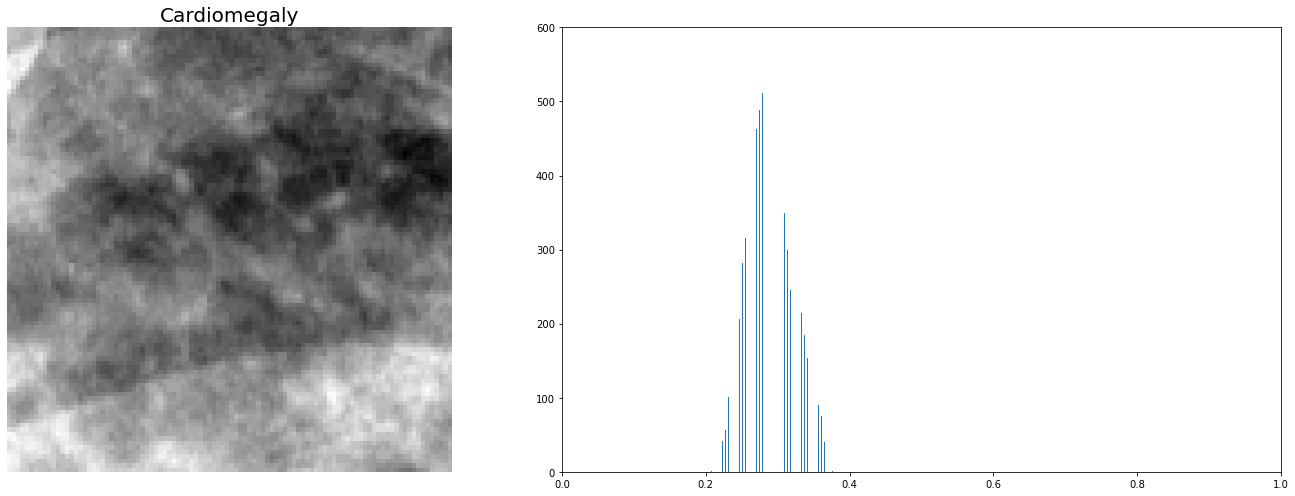

In [55]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Cardiomegaly']['Image Path'].values[4],
                   y=500, x=250, title='Cardiomegaly')

**Consolidation** - region of normally compressible lung tissue that has filled with liquid instead of air.

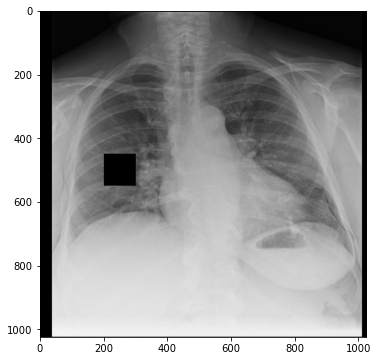

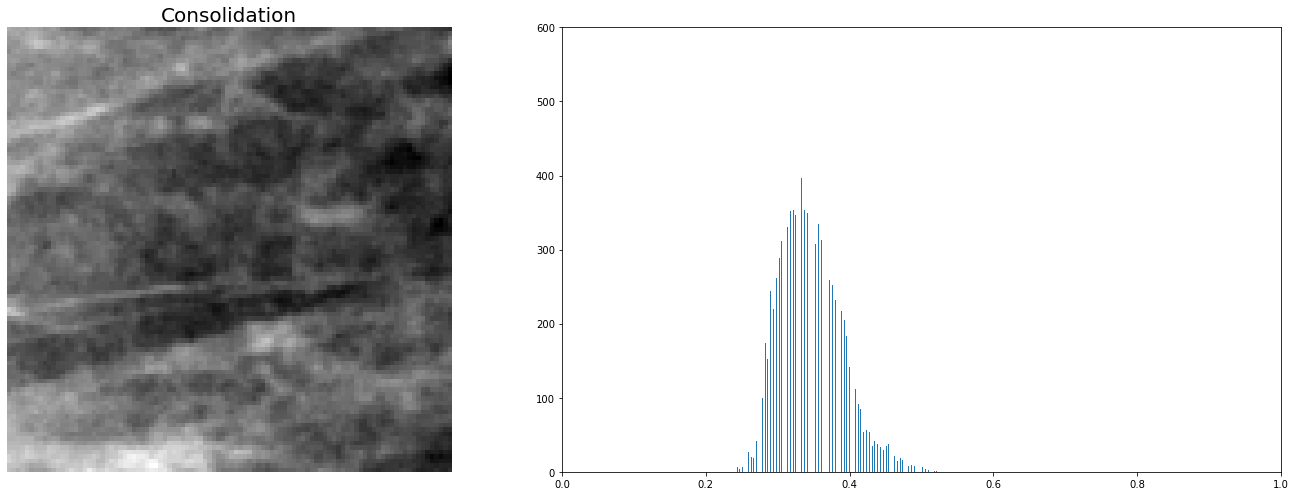

In [56]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Consolidation']['Image Path'].values[1],
                   y=450, x=200, title='Consolidation')

**Effusion** - abnormal accumulation of fluid in the pleural space between the lungs and the chest wall.

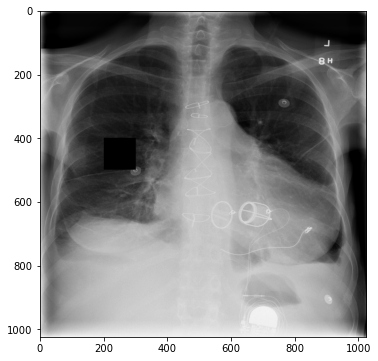

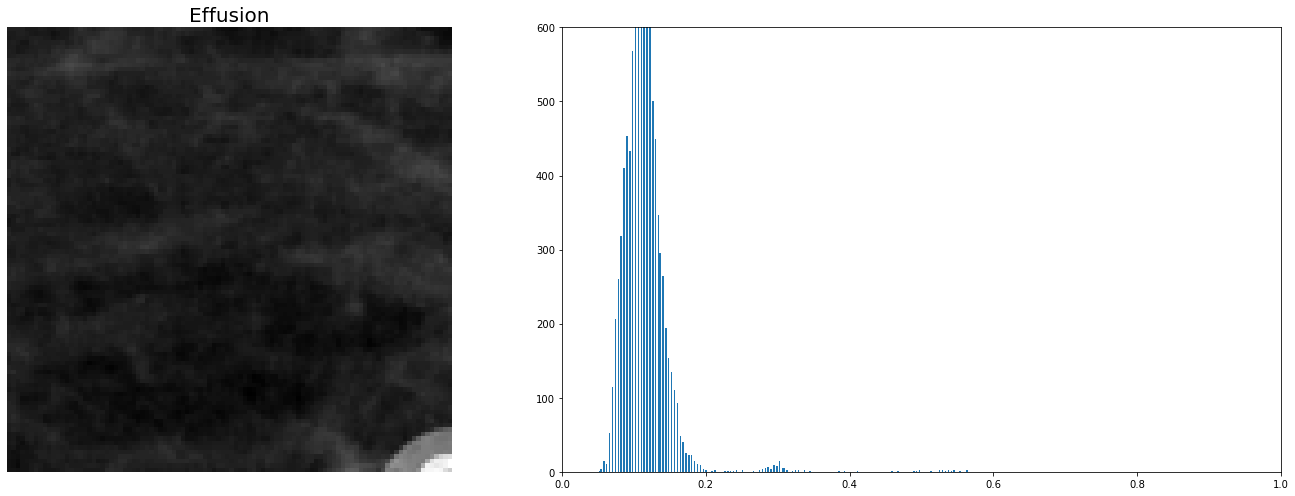

In [57]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Effusion']['Image Path'].values[2],
                   y=400, x=200, title='Effusion')

**Emphysema** - damaged air sacs (alveoli).

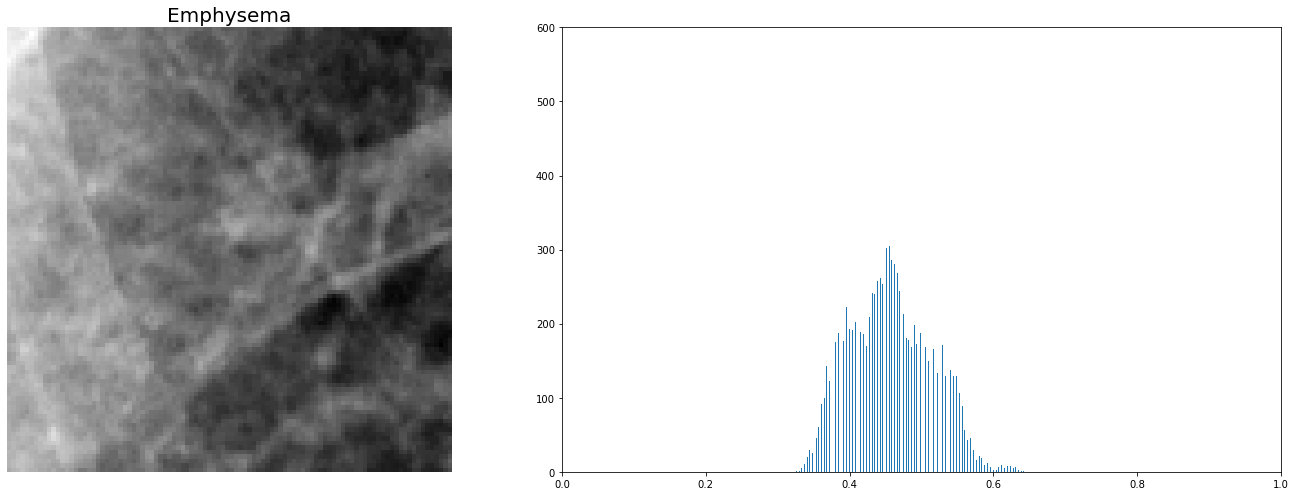

In [58]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Emphysema']['Image Path'].values[2],
                   y=500, x=200, title='Emphysema')

**Fibrosis** - damaged and scarred lung tissue.

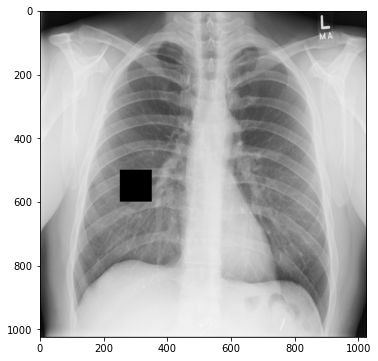

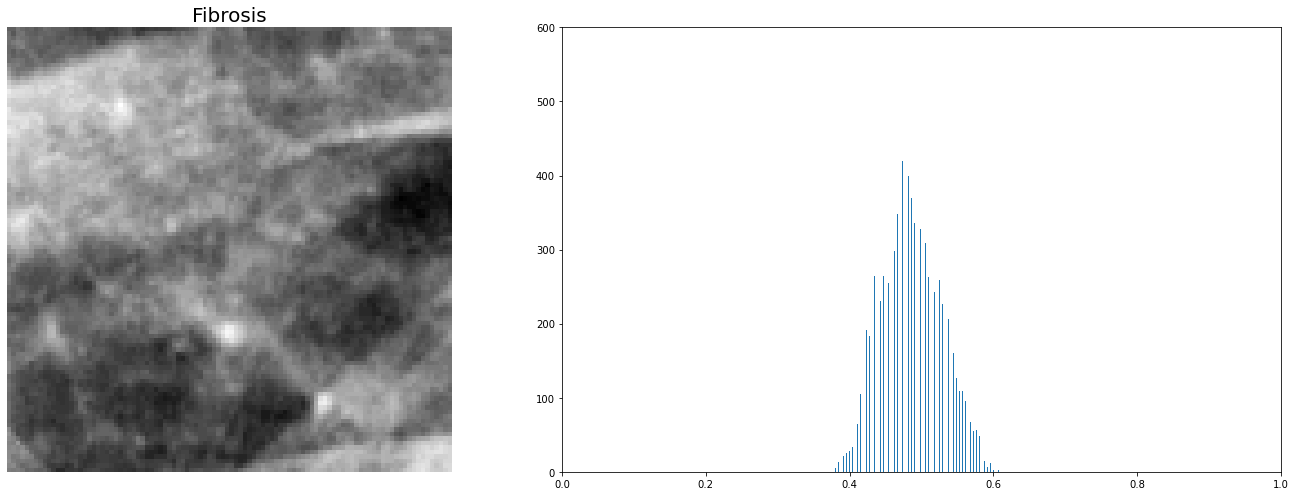

In [59]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Fibrosis']['Image Path'].values[2],
                   y=500, x=250, title='Fibrosis')

**Hernia** - abnormal exit of tissue or an organ through the wall of the cavity in which it normally resides.

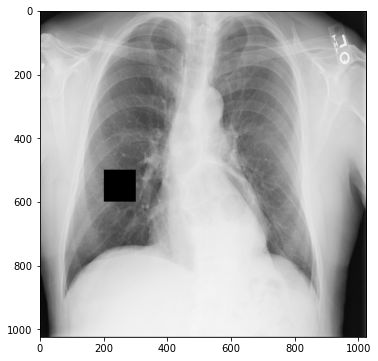

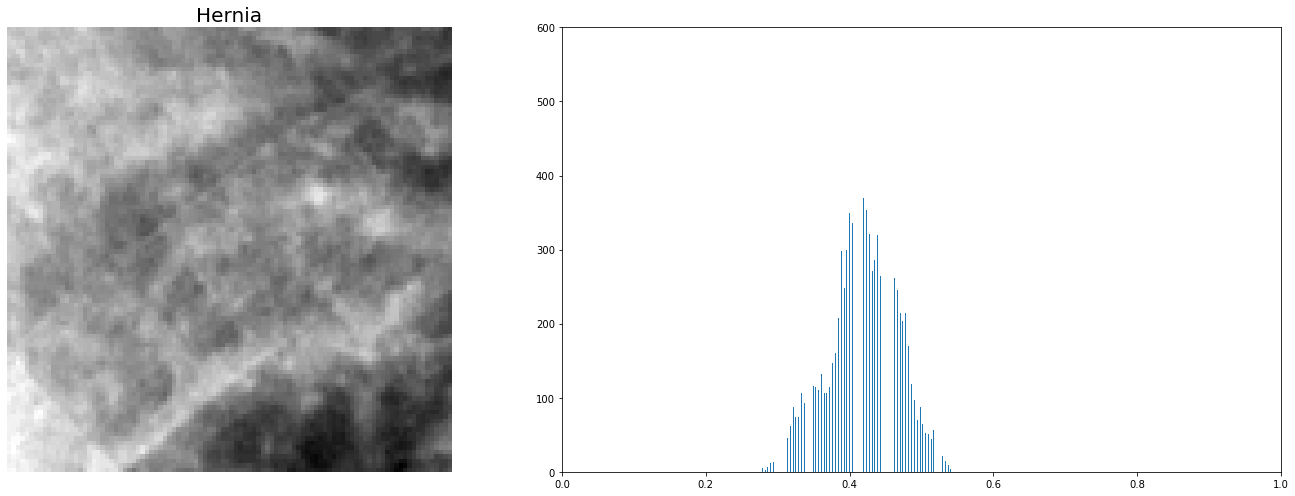

In [60]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Hernia']['Image Path'].values[2],
                   y=500, x=200, title='Hernia')

**Mass** - abnormal growth of tissue.

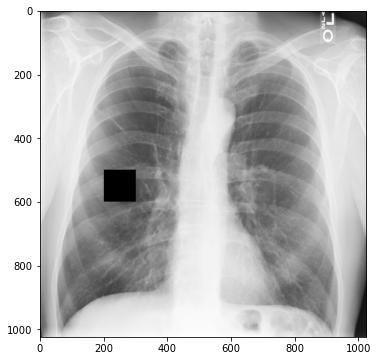

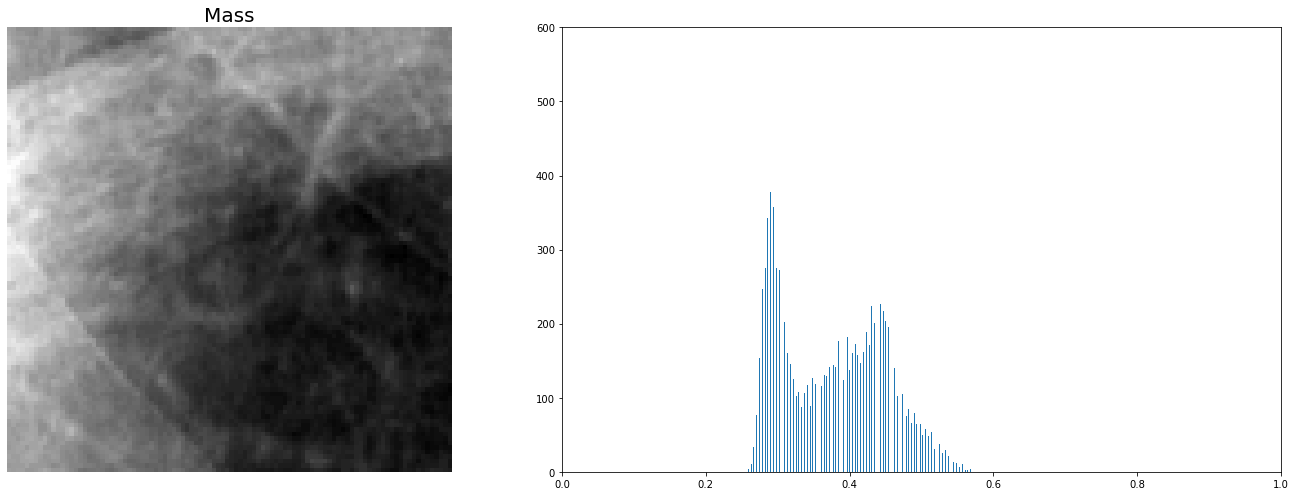

In [61]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Mass']['Image Path'].values[0],
                   y=500, x=200, title='Mass')

**Nodule** - lump.

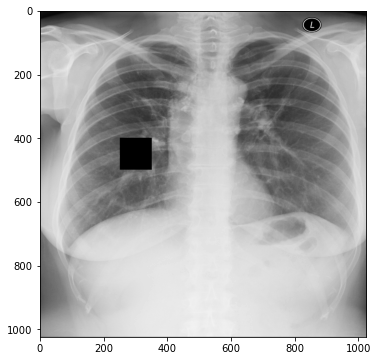

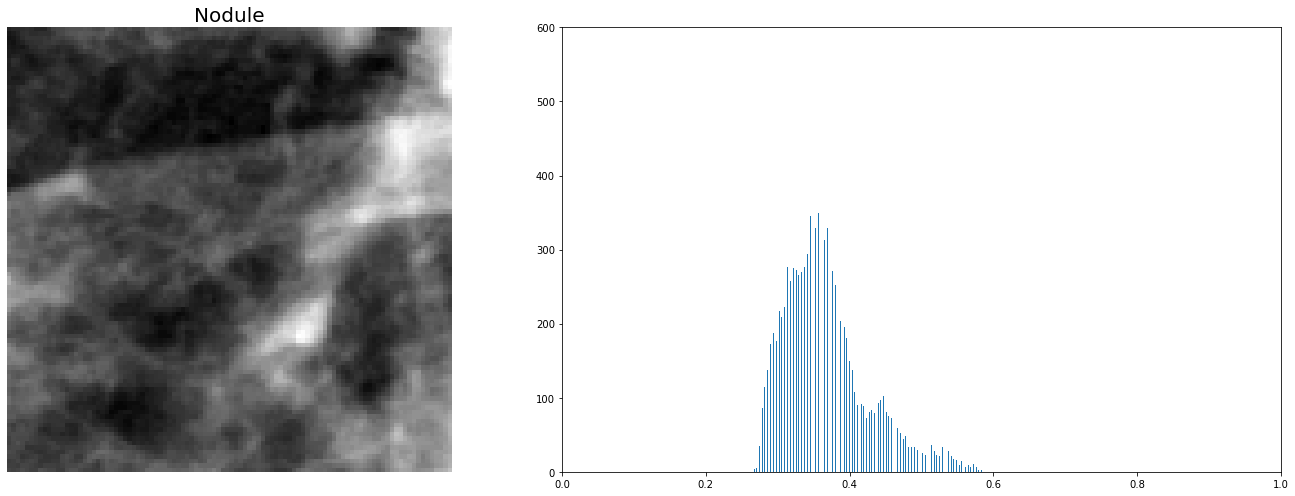

In [62]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Nodule']['Image Path'].values[2],
                   y=400, x=250, title='Nodule')

**Pleural Thickening** - increase in the bulkiness of one or both of the pulmonary pleurae.

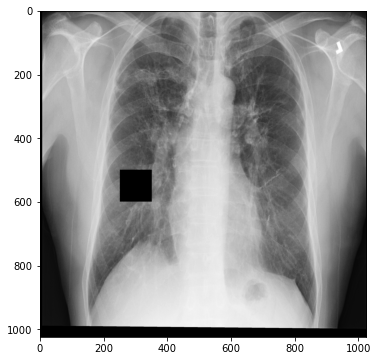

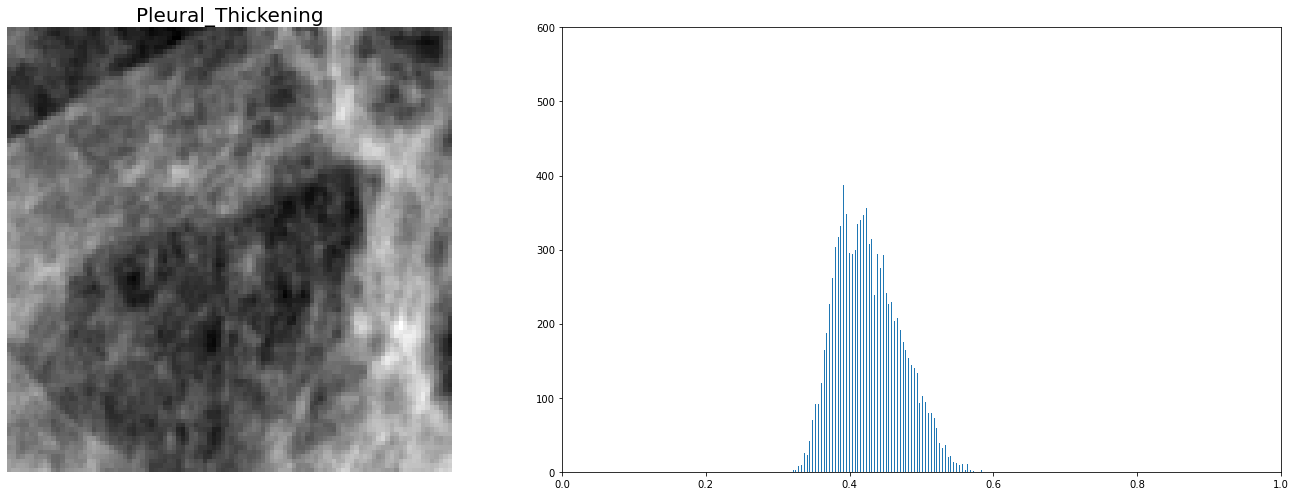

In [63]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Pleural_Thickening']['Image Path'].values[2],
                   y=500, x=250, title='Pleural_Thickening')

**Pneumothorax** - abnormal collection of air in the pleural space between the lung and the chest wall.

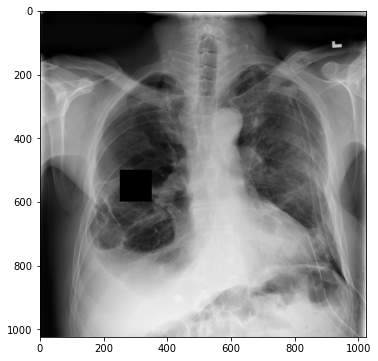

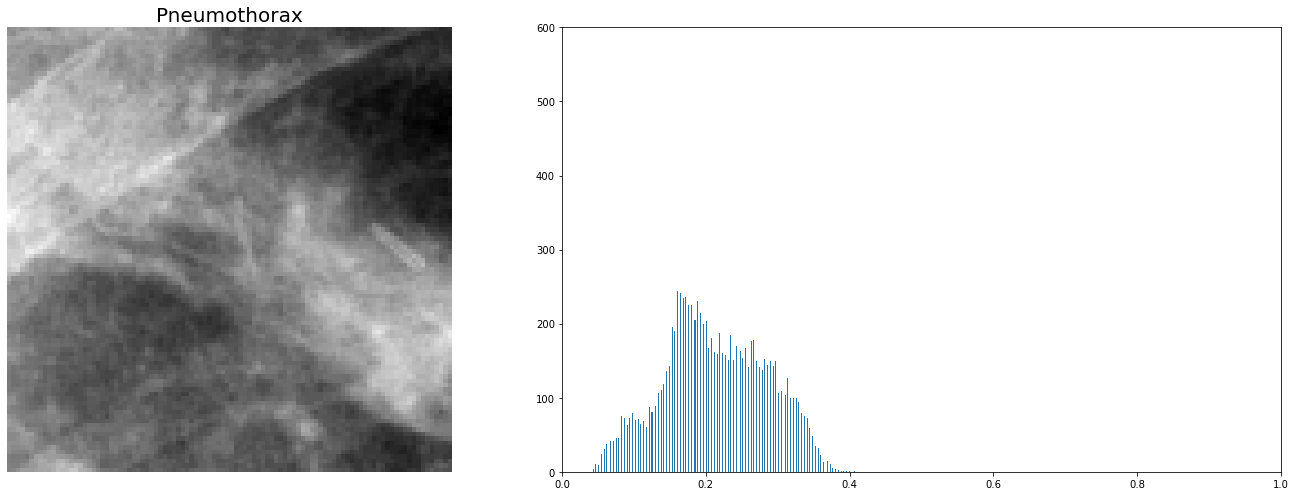

In [64]:
fragment_intensity(sample_df[sample_df['Finding Labels'] == 'Pneumothorax']['Image Path'].values[0],
                   y=500, x=250, title='Pneumothorax')

## Conclusions

In the dataset patients with pneumonia are aged mostly 20-70. There are slightly less females. The images of only pneumonia are taken mostly in PA view (though there is rather small difference considering the overall only pneumonia cases in the sample dataset), however while considered pneumonia with comorbidities there are more AP images.

There are only 1431 pneumonia cases in the whole dataset (of 110689 cases). Because of that the whole dataset will not be necessary for model training. That would introduce undesired class imbalance in the training dataset. Similarly, the validation dataset does not need very high class imbalance as well in this situation.

Patiens in the dataset in most cases have only one disease, howver there are some patiens diagnosed with 8 or more diseases. Pneumonia occurs mostly with Infiltration and Edema. 

In general pneumonia appers on the image as brighter spots than the healthy lung tissue. It may be challenging to state that judging from the intensity histogram of the whole image, since there can be objects other than patient contributing to the overall intensity, like annotations or wires. What is more, sometimes patient covers more of the image leaving less background and sometimes patient covers less of image leaving more background. Another approach of performing pixel-level assessments which tries to get around such obstacles is to choose only part of the image to analyze.

Pneumonia may look similar to other diseases, especially to non-radiologists. Some of the diseases, like Infiltration, Consolidation, Edema or Effusion, change image areas brightness as well, since fluid appears differently than air in the healthy lungs. Cardiomegaly on the other hand should pose no problem to the algorithm, because enlarged heart is significantly different than brighter spots in the lungs. Fibrosis probably may be confused with pneumonia. Other diseases causing air gathering in abnormal locations (Pneumothorax, Emphysema) probably won't be confused with pneumonia by the algorithm, because they present distinct features - air appears dark on the image in contrast to bright areas in the lungs.